In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

import math

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

            X = torch.cat((X,X,X),0)

        return X, y

In [4]:
df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
batch_size= 128

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
# df_test = df[df['Usage'] == 'PrivateTest']

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(48),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

training_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
# test_set = FERDataset(df_test, train_transforms)


training_generator = torch.utils.data.DataLoader(training_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
validation_generator = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
# train_loader = torch.utils.data.DataLoader(test_set,
#                                              batch_size=batch_size, shuffle=False,
#                                              num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
len(training_set)

28709

In [28]:
len(training_generator)

28800

In [13]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
    fig, axs = plt.subplots(1,2,figsize=(20,8))
    axs[0].plot(test_losses, label=label)
    axs[0].set_title("Test Loss")
    axs[1].plot(test_acc, label=label)
    axs[1].set_title("Test Accuracy")

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [14]:
def train(model, train_loader, optimizer, scheduler):
    model.train()
    pbar = tqdm(train_loader, position=0)
    running_loss = 0.0
    correct = 0
    processed = 0
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        loss = criterion(embeddings, target)
        running_loss += (loss.item() * data.size(0))
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

#         pred = embeddings.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         pred = (embeddings > 0.5).float()
#         correct += pred.eq(target.view_as(pred)).sum().item()
        correct += (torch.argmax(embeddings, dim=1) == target).float().sum()
        processed += len(data)

        train_acc.append(100*correct/processed)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')
        
    print('\t train_loss: ', running_loss / len(train_loader.dataset), ' | train_acc: ', correct / len(train_loader.dataset))
    
        
def test(model, test_loader):
    model.eval()
    best_acc = 0.
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += (criterion(output, target).item() * data.size(0))  # sum up batch loss
#         pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += (torch.argmax(output, dim=1) == target).float().sum()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    _cur_acc = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * _cur_acc))
    
    if _cur_acc > best_acc:
        print('* Update optimal model')
        best_acc = _cur_acc
        if not model_path is None:
            torch.save(model, model_path)
    
    
    valid_acc.append(100. * _cur_acc)
    
    return test_loss

In [15]:
class VGG16_baseline(nn.Module):
    def __init__(self, pretrained=False):
        super(VGG16_baseline, self).__init__()
        baseline = models.vgg16_bn(pretrained=pretrained)
        self.features = baseline.features
        self.avgpool = baseline.avgpool
        self.classifier = nn.Sequential(nn.Linear(25088, 4096, bias=True),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(4096, 4096, bias=True),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(4096, 7, bias=True))
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 25088)
        x = self.classifier(x)
        
        return x

In [24]:
model_path = None
device = torch.device('cuda')
model=VGG16_baseline(pretrained=False)
model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

  0%|          | 0/225 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.0019999999999999983 


Loss=1.7207826375961304 Batch_id=224 le=0.003064156314741575 Accuracy=25.45: 100%|██████████| 225/225 [00:26<00:00,  8.62it/s] 
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 1185/3589 (33.02%)

* Update optimal model
EPOCH: 1 LR: 0.003064156314741575 


Loss=1.4838634729385376 Batch_id=224 le=0.006004974445143111 Accuracy=38.51: 100%|██████████| 225/225 [00:26<00:00,  8.59it/s] 
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 1609/3589 (44.83%)

* Update optimal model
EPOCH: 2 LR: 0.006004974445143111 


Loss=1.3422800302505493 Batch_id=224 le=0.010127012128099425 Accuracy=46.52: 100%|██████████| 225/225 [00:26<00:00,  8.57it/s] 
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 1603/3589 (44.66%)

* Update optimal model
EPOCH: 3 LR: 0.010127012128099425 


Loss=1.1954898834228516 Batch_id=224 le=0.014455493268072585 Accuracy=51.96: 100%|██████████| 225/225 [00:26<00:00,  8.52it/s]
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 1826/3589 (50.88%)

* Update optimal model
EPOCH: 4 LR: 0.014455493268072585 


Loss=1.21372652053833 Batch_id=224 le=0.017966822189875425 Accuracy=55.34: 100%|██████████| 225/225 [00:26<00:00,  8.53it/s]  
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 1864/3589 (51.94%)

* Update optimal model
EPOCH: 5 LR: 0.017966822189875425 


Loss=1.196033239364624 Batch_id=224 le=0.01983064270566989 Accuracy=57.97: 100%|██████████| 225/225 [00:26<00:00,  8.53it/s]  
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 2024/3589 (56.39%)

* Update optimal model
EPOCH: 6 LR: 0.01983064270566989 


Loss=1.0285720825195312 Batch_id=224 le=0.019972502125976347 Accuracy=60.84: 100%|██████████| 225/225 [00:26<00:00,  8.52it/s]
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 2019/3589 (56.26%)

* Update optimal model
EPOCH: 7 LR: 0.019972502125976347 


Loss=1.021057367324829 Batch_id=224 le=0.019806789224759088 Accuracy=63.20: 100%|██████████| 225/225 [00:26<00:00,  8.50it/s] 
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 2010/3589 (56.00%)

* Update optimal model
EPOCH: 8 LR: 0.019806789224759088 


Loss=0.9423007369041443 Batch_id=224 le=0.019493574589509826 Accuracy=65.19: 100%|██████████| 225/225 [00:26<00:00,  8.51it/s]
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 2146/3589 (59.79%)

* Update optimal model
EPOCH: 9 LR: 0.019493574589509826 


Loss=1.0640771389007568 Batch_id=224 le=0.019037569259883688 Accuracy=67.64: 100%|██████████| 225/225 [00:26<00:00,  8.50it/s]
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 1998/3589 (55.67%)

* Update optimal model
EPOCH: 10 LR: 0.019037569259883688 


Loss=0.8869560956954956 Batch_id=224 le=0.0184456319804892 Accuracy=69.20: 100%|██████████| 225/225 [00:26<00:00,  8.48it/s]  
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 1984/3589 (55.28%)

* Update optimal model
EPOCH: 11 LR: 0.0184456319804892 


Loss=0.7880299687385559 Batch_id=224 le=0.0177266660389852 Accuracy=71.74: 100%|██████████| 225/225 [00:26<00:00,  8.48it/s]  
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 2183/3589 (60.82%)

* Update optimal model
EPOCH: 12 LR: 0.0177266660389852 


Loss=0.8512291312217712 Batch_id=205 le=0.016966205137781645 Accuracy=73.61:  92%|█████████▏| 206/225 [00:24<00:02,  8.42it/s]


KeyboardInterrupt: 

In [5]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [6]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.emb_dim = emb_dim
#         self.device = kwargs['device']
        
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv3 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):
        x1_emb = self.iconv1(x)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        x3_emb = self.iconv3(x)
        
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / QK.size(1)
        QK = torch.matmul(QK, QK.permute(0,2,1)).sum(1)
        QK = QK.sigmoid()
        QK = QK.unsqueeze(-1).unsqueeze(-1)
        
        
        x_out = (1 + QK) * x3_emb
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU(inplace=True)(x_out)
        
        x_out = x_out + x #residual
        
        return x_out

In [7]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(3, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64, 64, emb_dim=32).to(self.device)
        self.wf1 = Attention(128, 128, emb_dim=64).to(self.device)
        self.wf2 = Attention(256, 256, emb_dim=128).to(self.device)
        self.wf3 = Attention(512, 512, emb_dim=256).to(self.device)
        self.wf4 = Attention(1024, 1024, emb_dim=512).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

  0%|          | 0/225 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.0019999999999999983 


Loss=1.8106708526611328 Batch_id=224 le=0.0019999999999999983 Accuracy=25.15: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

	 train_loss:  1.9297533758448402  | train_acc:  tensor(0.2515, device='cuda:0')



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.2517, Accuracy: 869.0/3589 (24.21%)

* Update optimal model
EPOCH: 1 LR: 0.0020000445212102237 


Loss=1.6105784177780151 Batch_id=224 le=0.0020000445212102237 Accuracy=34.56: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  1.6686882905241895  | train_acc:  tensor(0.3456, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8379, Accuracy: 985.0/3589 (27.44%)

* Update optimal model
EPOCH: 2 LR: 0.0020000296616905014 


Loss=1.3165181875228882 Batch_id=224 le=0.0020000296616905014 Accuracy=44.33: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  1.4460182392865855  | train_acc:  tensor(0.4433, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.4296, Accuracy: 1632.0/3589 (45.47%)

* Update optimal model
EPOCH: 3 LR: 0.0020000179464574434 


Loss=1.5166144371032715 Batch_id=224 le=0.0020000179464574434 Accuracy=48.07: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  1.35524866139072  | train_acc:  tensor(0.4807, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.4133, Accuracy: 1628.0/3589 (45.36%)

* Update optimal model
EPOCH: 4 LR: 0.0020000175395923185 


Loss=1.362617015838623 Batch_id=224 le=0.0020000175395923185 Accuracy=50.76: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s] 

	 train_loss:  1.2998316165832788  | train_acc:  tensor(0.5076, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.4039, Accuracy: 1678.0/3589 (46.75%)

* Update optimal model
EPOCH: 5 LR: 0.0020000173056022134 


Loss=1.2524348497390747 Batch_id=224 le=0.0020000173056022134 Accuracy=51.65: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  1.2722340886996222  | train_acc:  tensor(0.5165, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.4436, Accuracy: 1593.0/3589 (44.39%)

* Update optimal model
EPOCH: 6 LR: 0.002000018298992868 


Loss=1.118680715560913 Batch_id=224 le=0.002000018298992868 Accuracy=53.68: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s] 

	 train_loss:  1.2200991188895596  | train_acc:  tensor(0.5368, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.3243, Accuracy: 1783.0/3589 (49.68%)

* Update optimal model
EPOCH: 7 LR: 0.002000015400428684 


Loss=1.4109828472137451 Batch_id=224 le=0.002000015400428684 Accuracy=55.90: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  1.1710775112124994  | train_acc:  tensor(0.5590, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2633, Accuracy: 1860.0/3589 (51.83%)

* Update optimal model
EPOCH: 8 LR: 0.002000014012528452 


Loss=1.1304219961166382 Batch_id=224 le=0.002000014012528452 Accuracy=56.87: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  1.1424546355492617  | train_acc:  tensor(0.5687, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2321, Accuracy: 1937.0/3589 (53.97%)

* Update optimal model
EPOCH: 9 LR: 0.002000013330554471 


Loss=1.1149868965148926 Batch_id=224 le=0.002000013330554471 Accuracy=58.08: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  1.1144451938239694  | train_acc:  tensor(0.5808, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2198, Accuracy: 1946.0/3589 (54.22%)

* Update optimal model
EPOCH: 10 LR: 0.0020000130651872186 


Loss=1.3337376117706299 Batch_id=224 le=0.0020000130651872186 Accuracy=59.04: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  1.0938732572232857  | train_acc:  tensor(0.5904, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2404, Accuracy: 1923.0/3589 (53.58%)

* Update optimal model
EPOCH: 11 LR: 0.0020000135095969776 


Loss=0.9909757375717163 Batch_id=224 le=0.0020000135095969776 Accuracy=59.60: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  1.0788672977432427  | train_acc:  tensor(0.5960, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2673, Accuracy: 1876.0/3589 (52.27%)

* Update optimal model
EPOCH: 12 LR: 0.0020000141015599493 


Loss=1.0217204093933105 Batch_id=224 le=0.0020000141015599493 Accuracy=60.27: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  1.0650134316481967  | train_acc:  tensor(0.6027, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2499, Accuracy: 1923.0/3589 (53.58%)

* Update optimal model
EPOCH: 13 LR: 0.002000013717496002 


Loss=0.6323030591011047 Batch_id=224 le=0.002000013717496002 Accuracy=60.75: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  1.0449933076964522  | train_acc:  tensor(0.6075, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1719, Accuracy: 2000.0/3589 (55.73%)

* Update optimal model
EPOCH: 14 LR: 0.0020000120588732836 


Loss=1.0027713775634766 Batch_id=224 le=0.0020000120588732836 Accuracy=61.23: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  1.0322871921893684  | train_acc:  tensor(0.6123, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1453, Accuracy: 2062.0/3589 (57.45%)

* Update optimal model
EPOCH: 15 LR: 0.002000011517940093 


Loss=1.1876516342163086 Batch_id=224 le=0.002000011517940093 Accuracy=61.64: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]


	 train_loss:  1.0229099195883555  | train_acc:  tensor(0.6164, device='cuda:0')


  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1702, Accuracy: 2008.0/3589 (55.95%)

* Update optimal model
EPOCH: 16 LR: 0.0020000120235848552 


Loss=0.9792997241020203 Batch_id=224 le=0.0020000120235848552 Accuracy=61.87: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  1.015284364932034  | train_acc:  tensor(0.6187, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0892, Accuracy: 2105.0/3589 (58.65%)

* Update optimal model
EPOCH: 17 LR: 0.0020000104178443077 


Loss=1.0279721021652222 Batch_id=224 le=0.0020000104178443077 Accuracy=62.70: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.9971322879559061  | train_acc:  tensor(0.6270, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1740, Accuracy: 1959.0/3589 (54.58%)

* Update optimal model
EPOCH: 18 LR: 0.0020000121026497106 


Loss=1.0285272598266602 Batch_id=224 le=0.0020000121026497106 Accuracy=62.89: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.9917431663971069  | train_acc:  tensor(0.6289, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0965, Accuracy: 2119.0/3589 (59.04%)

* Update optimal model
EPOCH: 19 LR: 0.002000010558143247 


Loss=0.7993600368499756 Batch_id=224 le=0.002000010558143247 Accuracy=62.87: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.9872091585177439  | train_acc:  tensor(0.6287, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1069, Accuracy: 2089.0/3589 (58.21%)

* Update optimal model
EPOCH: 20 LR: 0.002000010757965607 


Loss=1.3031179904937744 Batch_id=224 le=0.002000010757965607 Accuracy=63.51: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.9748597212431386  | train_acc:  tensor(0.6351, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1303, Accuracy: 2076.0/3589 (57.84%)

* Update optimal model
EPOCH: 21 LR: 0.0020000112181384998 


Loss=1.1900779008865356 Batch_id=224 le=0.0020000112181384998 Accuracy=63.74: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.9738652282566888  | train_acc:  tensor(0.6374, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1216, Accuracy: 2111.0/3589 (58.82%)

* Update optimal model
EPOCH: 22 LR: 0.002000011046108807 


Loss=0.7885708808898926 Batch_id=224 le=0.002000011046108807 Accuracy=64.28: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.9574686832747542  | train_acc:  tensor(0.6428, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1018, Accuracy: 2135.0/3589 (59.49%)

* Update optimal model
EPOCH: 23 LR: 0.0020000106601779782 


Loss=1.0516051054000854 Batch_id=224 le=0.0020000106601779782 Accuracy=64.27: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.9546234935606164  | train_acc:  tensor(0.6427, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0884, Accuracy: 2133.0/3589 (59.43%)

* Update optimal model
EPOCH: 24 LR: 0.0020000104010129277 


Loss=1.0276159048080444 Batch_id=224 le=0.0020000104010129277 Accuracy=64.86: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.9510449738606975  | train_acc:  tensor(0.6486, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0824, Accuracy: 2112.0/3589 (58.85%)

* Update optimal model
EPOCH: 25 LR: 0.00200001028748242 


Loss=0.9945996999740601 Batch_id=224 le=0.00200001028748242 Accuracy=64.80: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.94470896234316  | train_acc:  tensor(0.6480, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1009, Accuracy: 2086.0/3589 (58.12%)

* Update optimal model
EPOCH: 26 LR: 0.0020000106415949334 


Loss=0.7496457099914551 Batch_id=224 le=0.0020000106415949334 Accuracy=65.11: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.9355675130350687  | train_acc:  tensor(0.6511, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1398, Accuracy: 2029.0/3589 (56.53%)

* Update optimal model
EPOCH: 27 LR: 0.0020000114070066605 


Loss=0.8712818026542664 Batch_id=224 le=0.0020000114070066605 Accuracy=65.29: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.930548911498023  | train_acc:  tensor(0.6529, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1044, Accuracy: 2098.0/3589 (58.46%)

* Update optimal model
EPOCH: 28 LR: 0.0020000107105577376 


Loss=1.0064274072647095 Batch_id=224 le=0.0020000107105577376 Accuracy=65.54: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]


	 train_loss:  0.9271463643811523  | train_acc:  tensor(0.6554, device='cuda:0')


  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1038, Accuracy: 2115.0/3589 (58.93%)

* Update optimal model
EPOCH: 29 LR: 0.0020000106982015625 


Loss=0.8610618710517883 Batch_id=224 le=0.0020000106982015625 Accuracy=65.67: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.9218816657234764  | train_acc:  tensor(0.6567, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0927, Accuracy: 2118.0/3589 (59.01%)

* Update optimal model
EPOCH: 30 LR: 0.0020000104844825513 


Loss=0.8406438827514648 Batch_id=224 le=0.0020000104844825513 Accuracy=65.54: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.9165327412036814  | train_acc:  tensor(0.6554, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.2603, Accuracy: 1865.0/3589 (51.96%)

* Update optimal model
EPOCH: 31 LR: 0.002000013947035067 


Loss=0.7638731002807617 Batch_id=224 le=0.002000013947035067 Accuracy=66.24: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]


	 train_loss:  0.9095472335283932  | train_acc:  tensor(0.6624, device='cuda:0')


  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1005, Accuracy: 2122.0/3589 (59.13%)

* Update optimal model
EPOCH: 32 LR: 0.002000010634302614 


Loss=1.0515315532684326 Batch_id=224 le=0.002000010634302614 Accuracy=66.48: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.90273042541341  | train_acc:  tensor(0.6648, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1704, Accuracy: 2043.0/3589 (56.92%)

* Update optimal model
EPOCH: 33 LR: 0.0020000120273570114 


Loss=0.6612899303436279 Batch_id=224 le=0.0020000120273570114 Accuracy=66.54: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.8986220070218637  | train_acc:  tensor(0.6654, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0677, Accuracy: 2173.0/3589 (60.55%)

* Update optimal model
EPOCH: 34 LR: 0.0020000100096575213 


Loss=0.9069620966911316 Batch_id=224 le=0.0020000100096575213 Accuracy=66.86: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.8971374014846591  | train_acc:  tensor(0.6686, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1463, Accuracy: 2115.0/3589 (58.93%)

* Update optimal model
EPOCH: 35 LR: 0.0020000115370448247 


Loss=0.91529381275177 Batch_id=224 le=0.0020000115370448247 Accuracy=67.33: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]  

	 train_loss:  0.8891503733441583  | train_acc:  tensor(0.6733, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1951, Accuracy: 1999.0/3589 (55.70%)

* Update optimal model
EPOCH: 36 LR: 0.002000012541915737 


Loss=1.014435052871704 Batch_id=224 le=0.002000012541915737 Accuracy=67.09: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s] 

	 train_loss:  0.8892228731088759  | train_acc:  tensor(0.6709, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1277, Accuracy: 2121.0/3589 (59.10%)

* Update optimal model
EPOCH: 37 LR: 0.00200001116562238 


Loss=0.8966618180274963 Batch_id=224 le=0.00200001116562238 Accuracy=67.50: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  0.8805838184419971  | train_acc:  tensor(0.6750, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1259, Accuracy: 2083.0/3589 (58.04%)

* Update optimal model
EPOCH: 38 LR: 0.0020000111309408063 


Loss=0.9324309825897217 Batch_id=224 le=0.0020000111309408063 Accuracy=67.40: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  0.8743415701422116  | train_acc:  tensor(0.6740, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1401, Accuracy: 2101.0/3589 (58.54%)

* Update optimal model
EPOCH: 39 LR: 0.0020000114125181268 


Loss=1.0145783424377441 Batch_id=224 le=0.0020000114125181268 Accuracy=67.64: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.8728019621243583  | train_acc:  tensor(0.6764, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0688, Accuracy: 2161.0/3589 (60.21%)

* Update optimal model
EPOCH: 40 LR: 0.002000010029792835 


Loss=0.9060438871383667 Batch_id=224 le=0.002000010029792835 Accuracy=67.95: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.8652712371872612  | train_acc:  tensor(0.6795, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0790, Accuracy: 2162.0/3589 (60.24%)

* Update optimal model
EPOCH: 41 LR: 0.002000010222493402 


Loss=1.301931381225586 Batch_id=224 le=0.002000010222493402 Accuracy=68.07: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s] 

	 train_loss:  0.861493233598974  | train_acc:  tensor(0.6807, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1103, Accuracy: 2134.0/3589 (59.46%)

* Update optimal model
EPOCH: 42 LR: 0.002000010825057741 


Loss=1.2036943435668945 Batch_id=224 le=0.002000010825057741 Accuracy=67.96: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.861967107885837  | train_acc:  tensor(0.6796, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1201, Accuracy: 2138.0/3589 (59.57%)

* Update optimal model
EPOCH: 43 LR: 0.0020000110174834065 


Loss=1.0325798988342285 Batch_id=224 le=0.0020000110174834065 Accuracy=68.36: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  0.8582656605664148  | train_acc:  tensor(0.6836, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0948, Accuracy: 2120.0/3589 (59.07%)

* Update optimal model
EPOCH: 44 LR: 0.0020000105252451737 


Loss=1.1537889242172241 Batch_id=224 le=0.0020000105252451737 Accuracy=68.44: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  0.854744778049333  | train_acc:  tensor(0.6844, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0547, Accuracy: 2144.0/3589 (59.74%)

* Update optimal model
EPOCH: 45 LR: 0.002000009767927184 


Loss=1.2579506635665894 Batch_id=224 le=0.002000009767927184 Accuracy=68.48: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  0.8462949583716367  | train_acc:  tensor(0.6848, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0943, Accuracy: 2135.0/3589 (59.49%)

* Update optimal model
EPOCH: 46 LR: 0.002000010515577161 


Loss=0.9541342258453369 Batch_id=224 le=0.002000010515577161 Accuracy=68.64: 100%|██████████| 225/225 [00:54<00:00,  4.11it/s]

	 train_loss:  0.8464551494431233  | train_acc:  tensor(0.6864, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1887, Accuracy: 2030.0/3589 (56.56%)

* Update optimal model
EPOCH: 47 LR: 0.0020000124072239965 


Loss=1.1507567167282104 Batch_id=224 le=0.0020000124072239965 Accuracy=68.99: 100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

	 train_loss:  0.8390037463066691  | train_acc:  tensor(0.6899, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.0647, Accuracy: 2174.0/3589 (60.57%)

* Update optimal model
EPOCH: 48 LR: 0.0020000099542116893 


Loss=0.9875631332397461 Batch_id=224 le=0.0020000099542116893 Accuracy=68.94: 100%|██████████| 225/225 [00:54<00:00,  4.11it/s]

	 train_loss:  0.8407844268871644  | train_acc:  tensor(0.6894, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.1252, Accuracy: 2137.0/3589 (59.54%)

* Update optimal model
EPOCH: 49 LR: 0.0020000111163172643 


Loss=0.9069242477416992 Batch_id=224 le=0.0020000111163172643 Accuracy=68.92: 100%|██████████| 225/225 [00:54<00:00,  4.11it/s]

	 train_loss:  0.8360007248966541  | train_acc:  tensor(0.6892, device='cuda:0')



Test set: Average loss: 1.1792, Accuracy: 2026.0/3589 (56.45%)

* Update optimal model


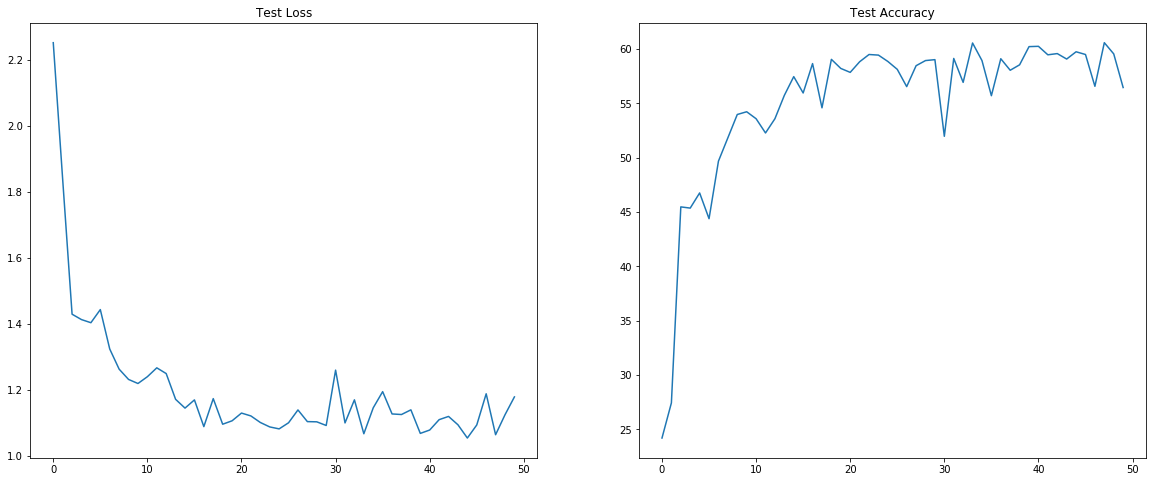

In [11]:
device = torch.device('cuda')
model=SVGG(device=device)
model.to(device)
epochs=50
optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
model_path = None
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    tloss = test(model, validation_generator)
    scheduler.step(tloss)
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

## Triplet loss

In [8]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

# ### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
# def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, labels) in enumerate(train_loader):
#         data, labels = data.to(device), labels.to(device)
#         optimizer.zero_grad()
#         embeddings = model(data)
#         indices_tuple = mining_func(embeddings, labels)
#         loss = loss_func(embeddings, labels, indices_tuple)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 20 == 0:
#             print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

# ### convenient function from pytorch-metric-learning ###
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester()
#     return tester.get_all_embeddings(dataset, model)

# ### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
# def test(train_set, test_set, model, accuracy_calculator):
#     train_embeddings, train_labels = get_all_embeddings(train_set, model)
#     test_embeddings, test_labels = get_all_embeddings(test_set, model)
#     print("Computing accuracy")
#     accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
#                                                 train_embeddings,
#                                                 np.squeeze(test_labels),
#                                                 np.squeeze(train_labels),
#                                                 False)
#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


In [9]:
batch_size= 128

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
# df_test = df[df['Usage'] == 'PrivateTest']

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(48),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

training_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
# test_set = FERDataset(df_test, train_transforms)


training_generator = torch.utils.data.DataLoader(training_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
validation_generator = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
# train_loader = torch.utils.data.DataLoader(test_set,
#                                              batch_size=batch_size, shuffle=False,
#                                              num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
def train(model, train_loader, optimizer, loss_func, mining_func, scheduler):
    model.train()
    pbar = tqdm(train_loader, position=0)
    running_loss = 0.0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, target)
        loss = loss_func(embeddings, target, indices_tuple)
        running_loss += (loss.item() * data.shape[0])
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

#         pred = embeddings.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         pred = (embeddings > 0.5).float()
#         correct += pred.eq(target.view_as(pred)).sum().item()
        correct += (torch.argmax(embeddings, dim=1) == target).float().sum()
        processed += len(data)

        train_acc.append(100*correct/processed)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')
        
    print('\t train_loss: ', running_loss / len(train_loader.dataset), ' | train_acc: ', correct / len(train_loader.dataset))
    
        
def test(model, test_loader):
    model.eval()
    best_acc = 0.
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += (criterion(output, target).item() * data.size(0))  # sum up batch loss
#         pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += (torch.argmax(output, dim=1) == target).float().sum()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    _cur_acc = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * _cur_acc))
    
    if _cur_acc > best_acc:
        print('* Update optimal model')
        best_acc = _cur_acc
        if not model_path is None:
            torch.save(model, model_path)
    
    
    valid_acc.append(100. * _cur_acc)
    
    return test_loss

  0%|          | 0/225 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.004 


Loss=0.10238195210695267 Batch_id=224 le=0.004 Accuracy=15.54: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]

	 train_loss:  0.10603448135522744  | train_acc:  tensor(0.1554, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 15.9406, Accuracy: 498.0/3589 (13.88%)

* Update optimal model
EPOCH: 1 LR: 0.004 


Loss=0.10188788920640945 Batch_id=224 le=0.004 Accuracy=14.71: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.1061851230874518  | train_acc:  tensor(0.1471, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.3430, Accuracy: 424.0/3589 (11.81%)

* Update optimal model
EPOCH: 2 LR: 0.004 


Loss=0.10592347383499146 Batch_id=224 le=0.004 Accuracy=14.63: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10517257571183027  | train_acc:  tensor(0.1463, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.6034, Accuracy: 576.0/3589 (16.05%)

* Update optimal model
EPOCH: 3 LR: 0.004 


Loss=0.10738416761159897 Batch_id=224 le=0.004 Accuracy=14.74: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10441510547717424  | train_acc:  tensor(0.1474, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0100, Accuracy: 282.0/3589 (7.86%)

* Update optimal model
EPOCH: 4 LR: 0.004 


Loss=0.10290367901325226 Batch_id=224 le=0.004 Accuracy=15.58: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10435194545940461  | train_acc:  tensor(0.1558, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.2694, Accuracy: 565.0/3589 (15.74%)

* Update optimal model
EPOCH: 5 LR: 0.004 


Loss=0.10088241100311279 Batch_id=224 le=0.004 Accuracy=20.53: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10384048909086964  | train_acc:  tensor(0.2053, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.3619, Accuracy: 515.0/3589 (14.35%)

* Update optimal model
EPOCH: 6 LR: 0.004 


Loss=0.1052817702293396 Batch_id=224 le=0.004 Accuracy=22.41: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s] 

	 train_loss:  0.10424331207709558  | train_acc:  tensor(0.2241, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.0191, Accuracy: 592.0/3589 (16.49%)

* Update optimal model
EPOCH: 7 LR: 0.004 


Loss=0.10003181546926498 Batch_id=224 le=0.004 Accuracy=22.28: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10390747663712874  | train_acc:  tensor(0.2228, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.0563, Accuracy: 943.0/3589 (26.27%)

* Update optimal model
EPOCH: 8 LR: 0.004 


Loss=0.10571583360433578 Batch_id=224 le=0.004 Accuracy=23.42: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10363335430486112  | train_acc:  tensor(0.2342, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9147, Accuracy: 878.0/3589 (24.46%)

* Update optimal model
EPOCH: 9 LR: 0.004 


Loss=0.10273745656013489 Batch_id=224 le=0.004 Accuracy=23.29: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.10349152198222834  | train_acc:  tensor(0.2329, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9449, Accuracy: 805.0/3589 (22.43%)

* Update optimal model
EPOCH: 10 LR: 0.004 


Loss=0.10266217589378357 Batch_id=224 le=0.004 Accuracy=24.78: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10348889466288562  | train_acc:  tensor(0.2478, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9359, Accuracy: 979.0/3589 (27.28%)

* Update optimal model
EPOCH: 11 LR: 0.004 


Loss=0.10410048067569733 Batch_id=224 le=0.004 Accuracy=25.63: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10335959990317556  | train_acc:  tensor(0.2563, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8590, Accuracy: 988.0/3589 (27.53%)

* Update optimal model
EPOCH: 12 LR: 0.004 


Loss=0.10689283907413483 Batch_id=224 le=0.004 Accuracy=26.55: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.10329408996180102  | train_acc:  tensor(0.2655, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8253, Accuracy: 1082.0/3589 (30.15%)

* Update optimal model
EPOCH: 13 LR: 0.004 


Loss=0.09973767399787903 Batch_id=224 le=0.004 Accuracy=27.27: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10325037347759264  | train_acc:  tensor(0.2727, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8462, Accuracy: 981.0/3589 (27.33%)

* Update optimal model
EPOCH: 14 LR: 0.004 


Loss=0.09812963008880615 Batch_id=224 le=0.004 Accuracy=26.60: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10316985545559834  | train_acc:  tensor(0.2660, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.0705, Accuracy: 683.0/3589 (19.03%)

* Update optimal model
EPOCH: 15 LR: 0.004 


Loss=0.10343033820390701 Batch_id=224 le=0.004 Accuracy=26.48: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.1031222158948943  | train_acc:  tensor(0.2648, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9430, Accuracy: 988.0/3589 (27.53%)

* Update optimal model
EPOCH: 16 LR: 0.004 


Loss=0.10414116084575653 Batch_id=224 le=0.004 Accuracy=26.88: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10281105072428397  | train_acc:  tensor(0.2688, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8481, Accuracy: 1130.0/3589 (31.49%)

* Update optimal model
EPOCH: 17 LR: 0.004 


Loss=0.10196443647146225 Batch_id=224 le=0.004 Accuracy=26.49: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.10319895005224267  | train_acc:  tensor(0.2649, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.0124, Accuracy: 788.0/3589 (21.96%)

* Update optimal model
EPOCH: 18 LR: 0.004 


Loss=0.10332094132900238 Batch_id=224 le=0.004 Accuracy=26.06: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.102936088614792  | train_acc:  tensor(0.2606, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9345, Accuracy: 983.0/3589 (27.39%)

* Update optimal model
EPOCH: 19 LR: 0.004 


Loss=0.10178664326667786 Batch_id=224 le=0.004 Accuracy=27.08: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10320918571924506  | train_acc:  tensor(0.2708, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8964, Accuracy: 910.0/3589 (25.36%)

* Update optimal model
EPOCH: 20 LR: 0.004 


Loss=0.09850277006626129 Batch_id=224 le=0.004 Accuracy=26.43: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10286119161039074  | train_acc:  tensor(0.2643, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9559, Accuracy: 888.0/3589 (24.74%)

* Update optimal model
EPOCH: 21 LR: 0.004 


Loss=0.0966576337814331 Batch_id=224 le=0.004 Accuracy=27.34: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s] 

	 train_loss:  0.10279859287445064  | train_acc:  tensor(0.2734, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9743, Accuracy: 770.0/3589 (21.45%)

* Update optimal model
EPOCH: 22 LR: 0.002 


Loss=0.09979917854070663 Batch_id=224 le=0.002 Accuracy=27.84: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.1028145505338902  | train_acc:  tensor(0.2784, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8510, Accuracy: 1008.0/3589 (28.09%)

* Update optimal model
EPOCH: 23 LR: 0.002 


Loss=0.10593874752521515 Batch_id=224 le=0.002 Accuracy=27.39: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10303983611089981  | train_acc:  tensor(0.2739, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9154, Accuracy: 922.0/3589 (25.69%)

* Update optimal model
EPOCH: 24 LR: 0.002 


Loss=0.09991906583309174 Batch_id=224 le=0.002 Accuracy=27.35: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.10287899446558432  | train_acc:  tensor(0.2735, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9270, Accuracy: 907.0/3589 (25.27%)

* Update optimal model
EPOCH: 25 LR: 0.002 


Loss=0.09913326054811478 Batch_id=224 le=0.002 Accuracy=28.27: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

	 train_loss:  0.10258243201096325  | train_acc:  tensor(0.2827, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9226, Accuracy: 968.0/3589 (26.97%)

* Update optimal model
EPOCH: 26 LR: 0.002 


Loss=0.10636085271835327 Batch_id=224 le=0.002 Accuracy=27.91: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]


	 train_loss:  0.10283693078169732  | train_acc:  tensor(0.2791, device='cuda:0')


  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8829, Accuracy: 958.0/3589 (26.69%)

* Update optimal model
EPOCH: 27 LR: 0.002 


Loss=0.10699782520532608 Batch_id=224 le=0.002 Accuracy=27.88: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.10308407905081306  | train_acc:  tensor(0.2788, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9276, Accuracy: 864.0/3589 (24.07%)

* Update optimal model
EPOCH: 28 LR: 0.002 


Loss=0.10558689385652542 Batch_id=224 le=0.002 Accuracy=28.33: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]


	 train_loss:  0.10295609633811253  | train_acc:  tensor(0.2833, device='cuda:0')


  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9604, Accuracy: 892.0/3589 (24.85%)

* Update optimal model
EPOCH: 29 LR: 0.002 


Loss=0.10281692445278168 Batch_id=224 le=0.002 Accuracy=28.20: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]


	 train_loss:  0.10296951021741287  | train_acc:  tensor(0.2820, device='cuda:0')


  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9640, Accuracy: 794.0/3589 (22.12%)

* Update optimal model
EPOCH: 30 LR: 0.002 


Loss=0.10046332329511642 Batch_id=224 le=0.002 Accuracy=28.81: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10296700309275991  | train_acc:  tensor(0.2881, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.9045, Accuracy: 932.0/3589 (25.97%)

* Update optimal model
EPOCH: 31 LR: 0.001 


Loss=0.09890596568584442 Batch_id=224 le=0.001 Accuracy=28.83: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.1026016775556416  | train_acc:  tensor(0.2883, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8629, Accuracy: 983.0/3589 (27.39%)

* Update optimal model
EPOCH: 32 LR: 0.001 


Loss=0.09669100493192673 Batch_id=224 le=0.001 Accuracy=28.92: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10268540977118527  | train_acc:  tensor(0.2892, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8631, Accuracy: 1014.0/3589 (28.25%)

* Update optimal model
EPOCH: 33 LR: 0.001 


Loss=0.09931915253400803 Batch_id=224 le=0.001 Accuracy=29.14: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10292513856248482  | train_acc:  tensor(0.2914, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8580, Accuracy: 1055.0/3589 (29.40%)

* Update optimal model
EPOCH: 34 LR: 0.001 


Loss=0.10960660129785538 Batch_id=224 le=0.001 Accuracy=29.26: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10296922696896359  | train_acc:  tensor(0.2926, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8684, Accuracy: 971.0/3589 (27.05%)

* Update optimal model
EPOCH: 35 LR: 0.001 


Loss=0.10337109118700027 Batch_id=224 le=0.001 Accuracy=29.11: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10303453274745711  | train_acc:  tensor(0.2911, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8623, Accuracy: 995.0/3589 (27.72%)

* Update optimal model
EPOCH: 36 LR: 0.001 


Loss=0.1026846170425415 Batch_id=224 le=0.001 Accuracy=28.92: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s] 

	 train_loss:  0.1029045768464935  | train_acc:  tensor(0.2892, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8496, Accuracy: 1056.0/3589 (29.42%)

* Update optimal model
EPOCH: 37 LR: 0.001 


Loss=0.09871789813041687 Batch_id=224 le=0.001 Accuracy=28.95: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10297734878305614  | train_acc:  tensor(0.2895, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8604, Accuracy: 1009.0/3589 (28.11%)

* Update optimal model
EPOCH: 38 LR: 0.001 


Loss=0.10472305864095688 Batch_id=224 le=0.001 Accuracy=29.25: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10296203369123111  | train_acc:  tensor(0.2925, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8502, Accuracy: 1047.0/3589 (29.17%)

* Update optimal model
EPOCH: 39 LR: 0.001 


Loss=0.09869715571403503 Batch_id=224 le=0.001 Accuracy=29.41: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10297664860858742  | train_acc:  tensor(0.2941, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8307, Accuracy: 1015.0/3589 (28.28%)

* Update optimal model
EPOCH: 40 LR: 0.0005 


Loss=0.10014905780553818 Batch_id=224 le=0.0005 Accuracy=29.55: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10277454844478107  | train_acc:  tensor(0.2955, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8584, Accuracy: 1020.0/3589 (28.42%)

* Update optimal model
EPOCH: 41 LR: 0.0005 


Loss=0.09797754883766174 Batch_id=224 le=0.0005 Accuracy=29.73: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.10294833293512218  | train_acc:  tensor(0.2973, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8471, Accuracy: 1014.0/3589 (28.25%)

* Update optimal model
EPOCH: 42 LR: 0.0005 


Loss=0.09344352781772614 Batch_id=224 le=0.0005 Accuracy=29.91: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.1032205743208388  | train_acc:  tensor(0.2991, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8442, Accuracy: 1029.0/3589 (28.67%)

* Update optimal model
EPOCH: 43 LR: 0.0005 


Loss=0.09763127565383911 Batch_id=224 le=0.0005 Accuracy=29.81: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10294884647993031  | train_acc:  tensor(0.2981, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8859, Accuracy: 938.0/3589 (26.14%)

* Update optimal model
EPOCH: 44 LR: 0.0005 


Loss=0.09635117650032043 Batch_id=224 le=0.0005 Accuracy=29.76: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10305684788203247  | train_acc:  tensor(0.2976, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8392, Accuracy: 986.0/3589 (27.47%)

* Update optimal model
EPOCH: 45 LR: 0.0005 


Loss=0.10352538526058197 Batch_id=224 le=0.0005 Accuracy=29.81: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10306218399413639  | train_acc:  tensor(0.2981, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8322, Accuracy: 1025.0/3589 (28.56%)

* Update optimal model
EPOCH: 46 LR: 0.0005 


Loss=0.10166792571544647 Batch_id=224 le=0.0005 Accuracy=30.04: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10313074920661124  | train_acc:  tensor(0.3004, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8332, Accuracy: 992.0/3589 (27.64%)

* Update optimal model
EPOCH: 47 LR: 0.0005 


Loss=0.10319775342941284 Batch_id=224 le=0.0005 Accuracy=30.10: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.10302849867745101  | train_acc:  tensor(0.3010, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8172, Accuracy: 1015.0/3589 (28.28%)

* Update optimal model
EPOCH: 48 LR: 0.0005 


Loss=0.09396987408399582 Batch_id=224 le=0.0005 Accuracy=29.85: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.1030729000277789  | train_acc:  tensor(0.2985, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8508, Accuracy: 978.0/3589 (27.25%)

* Update optimal model
EPOCH: 49 LR: 0.0005 


Loss=0.10683128982782364 Batch_id=224 le=0.0005 Accuracy=29.87: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.10314063775685353  | train_acc:  tensor(0.2987, device='cuda:0')



Test set: Average loss: 1.8483, Accuracy: 1013.0/3589 (28.23%)

* Update optimal model


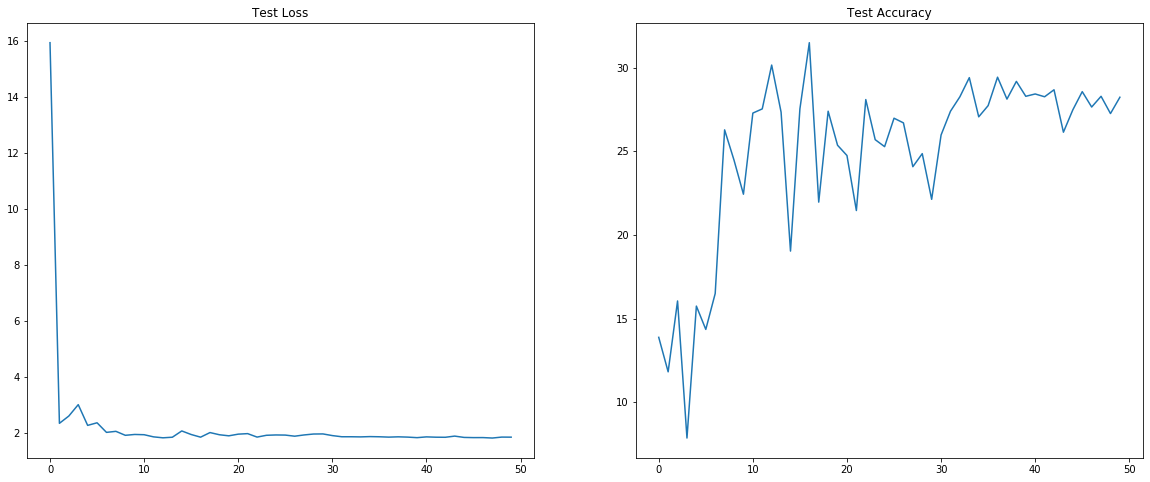

In [12]:
model_path = None
device = torch.device('cuda')
model=SVGG(device=device)
model.to(device)
epochs=50
optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=9e-4)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=False)

input_size=(3,48,48)
model_path = None
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer, loss_func, mining_func, scheduler)
    tloss = test(model, validation_generator)
    scheduler.step(tloss)
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

  0%|          | 0/225 [00:00<?, ?it/s]

EPOCH: 50 LR: 0.0005 


Loss=0.10340596735477448 Batch_id=224 le=0.0005 Accuracy=30.25: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

	 train_loss:  0.10324832610974113  | train_acc:  tensor(0.3025, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8310, Accuracy: 983.0/3589 (27.39%)

* Update optimal model
EPOCH: 51 LR: 0.0005 


Loss=0.1064733937382698 Batch_id=224 le=0.0005 Accuracy=30.19: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s] 

	 train_loss:  0.10334148423181706  | train_acc:  tensor(0.3019, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8540, Accuracy: 960.0/3589 (26.75%)

* Update optimal model
EPOCH: 52 LR: 0.0005 


Loss=0.09681188315153122 Batch_id=224 le=0.0005 Accuracy=30.13: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s]

	 train_loss:  0.10311031297823492  | train_acc:  tensor(0.3013, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8030, Accuracy: 1060.0/3589 (29.53%)

* Update optimal model
EPOCH: 53 LR: 0.0005 


Loss=0.09902167320251465 Batch_id=224 le=0.0005 Accuracy=30.00: 100%|██████████| 225/225 [00:54<00:00,  4.17it/s]

	 train_loss:  0.10311935967697138  | train_acc:  tensor(0.3000, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8407, Accuracy: 1000.0/3589 (27.86%)

* Update optimal model
EPOCH: 54 LR: 0.0005 


Loss=0.0989862009882927 Batch_id=224 le=0.0005 Accuracy=29.99: 100%|██████████| 225/225 [00:53<00:00,  4.17it/s] 

	 train_loss:  0.10309460791940371  | train_acc:  tensor(0.2999, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8320, Accuracy: 1020.0/3589 (28.42%)

* Update optimal model
EPOCH: 55 LR: 0.0005 


Loss=0.09841505438089371 Batch_id=224 le=0.0005 Accuracy=30.00: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10329156982010736  | train_acc:  tensor(0.3000, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8069, Accuracy: 1007.0/3589 (28.06%)

* Update optimal model
EPOCH: 56 LR: 0.0005 


Loss=0.10288707911968231 Batch_id=224 le=0.0005 Accuracy=29.69: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s]

	 train_loss:  0.1034010817057752  | train_acc:  tensor(0.2969, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8236, Accuracy: 1013.0/3589 (28.23%)

* Update optimal model
EPOCH: 57 LR: 0.0005 


Loss=0.0984119102358818 Batch_id=224 le=0.0005 Accuracy=29.68: 100%|██████████| 225/225 [00:54<00:00,  4.16it/s] 

	 train_loss:  0.1029977915586214  | train_acc:  tensor(0.2968, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8122, Accuracy: 1045.0/3589 (29.12%)

* Update optimal model
EPOCH: 58 LR: 0.0005 


Loss=0.10027779638767242 Batch_id=224 le=0.0005 Accuracy=30.06: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.1032499792152589  | train_acc:  tensor(0.3006, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8347, Accuracy: 955.0/3589 (26.61%)

* Update optimal model
EPOCH: 59 LR: 0.0005 


Loss=0.1012144461274147 Batch_id=224 le=0.0005 Accuracy=29.98: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s] 

	 train_loss:  0.10348440107522479  | train_acc:  tensor(0.2998, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8189, Accuracy: 983.0/3589 (27.39%)

* Update optimal model
EPOCH: 60 LR: 0.0005 


Loss=0.10075782239437103 Batch_id=224 le=0.0005 Accuracy=30.05: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10345502938207005  | train_acc:  tensor(0.3005, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8433, Accuracy: 973.0/3589 (27.11%)

* Update optimal model
EPOCH: 61 LR: 0.0005 


Loss=0.10693426430225372 Batch_id=224 le=0.0005 Accuracy=30.10: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.1031412949258828  | train_acc:  tensor(0.3010, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8529, Accuracy: 957.0/3589 (26.66%)

* Update optimal model
EPOCH: 62 LR: 0.00025 


Loss=0.10048660635948181 Batch_id=224 le=0.00025 Accuracy=30.25: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10355687011761901  | train_acc:  tensor(0.3025, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8307, Accuracy: 984.0/3589 (27.42%)

* Update optimal model
EPOCH: 63 LR: 0.00025 


Loss=0.09896160662174225 Batch_id=224 le=0.00025 Accuracy=30.37: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10353999657345489  | train_acc:  tensor(0.3037, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8237, Accuracy: 1010.0/3589 (28.14%)

* Update optimal model
EPOCH: 64 LR: 0.00025 


Loss=0.10528560727834702 Batch_id=224 le=0.00025 Accuracy=30.37: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10343475922308412  | train_acc:  tensor(0.3037, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8279, Accuracy: 990.0/3589 (27.58%)

* Update optimal model
EPOCH: 65 LR: 0.00025 


Loss=0.10896272957324982 Batch_id=224 le=0.00025 Accuracy=30.73: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.1036289305713567  | train_acc:  tensor(0.3073, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8237, Accuracy: 995.0/3589 (27.72%)

* Update optimal model
EPOCH: 66 LR: 0.00025 


Loss=0.09469284862279892 Batch_id=224 le=0.00025 Accuracy=30.72: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.1035007574267574  | train_acc:  tensor(0.3072, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8178, Accuracy: 994.0/3589 (27.70%)

* Update optimal model
EPOCH: 67 LR: 0.00025 


Loss=0.10274632275104523 Batch_id=224 le=0.00025 Accuracy=30.77: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10357584348033101  | train_acc:  tensor(0.3077, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8237, Accuracy: 999.0/3589 (27.84%)

* Update optimal model
EPOCH: 68 LR: 0.00025 


Loss=0.0857357382774353 Batch_id=224 le=0.00025 Accuracy=30.83: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s] 

	 train_loss:  0.1037854356445021  | train_acc:  tensor(0.3083, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8142, Accuracy: 1022.0/3589 (28.48%)

* Update optimal model
EPOCH: 69 LR: 0.00025 


Loss=0.10172257572412491 Batch_id=224 le=0.00025 Accuracy=30.89: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10404510022049526  | train_acc:  tensor(0.3089, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8229, Accuracy: 993.0/3589 (27.67%)

* Update optimal model
EPOCH: 70 LR: 0.00025 


Loss=0.09562920778989792 Batch_id=224 le=0.00025 Accuracy=30.89: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10399260427460882  | train_acc:  tensor(0.3089, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8277, Accuracy: 992.0/3589 (27.64%)

* Update optimal model
EPOCH: 71 LR: 0.000125 


Loss=0.09988456964492798 Batch_id=224 le=0.000125 Accuracy=30.88: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10394256152289179  | train_acc:  tensor(0.3088, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8228, Accuracy: 1018.0/3589 (28.36%)

* Update optimal model
EPOCH: 72 LR: 0.000125 


Loss=0.1027238667011261 Batch_id=224 le=0.000125 Accuracy=31.11: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s] 

	 train_loss:  0.1041666489137187  | train_acc:  tensor(0.3111, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8154, Accuracy: 1016.0/3589 (28.31%)

* Update optimal model
EPOCH: 73 LR: 0.000125 


Loss=0.10108773410320282 Batch_id=224 le=0.000125 Accuracy=30.79: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10408503385348614  | train_acc:  tensor(0.3079, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8291, Accuracy: 1018.0/3589 (28.36%)

* Update optimal model
EPOCH: 74 LR: 0.000125 


Loss=0.10693887621164322 Batch_id=224 le=0.000125 Accuracy=30.76: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10386402964132109  | train_acc:  tensor(0.3076, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8228, Accuracy: 1025.0/3589 (28.56%)

* Update optimal model
EPOCH: 75 LR: 0.000125 


Loss=0.1014329046010971 Batch_id=224 le=0.000125 Accuracy=31.01: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s] 

	 train_loss:  0.10422096071887645  | train_acc:  tensor(0.3101, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8287, Accuracy: 1007.0/3589 (28.06%)

* Update optimal model
EPOCH: 76 LR: 0.000125 


Loss=0.11135465651750565 Batch_id=224 le=0.000125 Accuracy=30.91: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.10421579785268963  | train_acc:  tensor(0.3091, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8398, Accuracy: 985.0/3589 (27.44%)

* Update optimal model
EPOCH: 77 LR: 0.000125 


Loss=0.10603410005569458 Batch_id=224 le=0.000125 Accuracy=31.32: 100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

	 train_loss:  0.10421045037072307  | train_acc:  tensor(0.3132, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8211, Accuracy: 1000.0/3589 (27.86%)

* Update optimal model
EPOCH: 78 LR: 0.000125 


Loss=0.11005540192127228 Batch_id=224 le=0.000125 Accuracy=31.07: 100%|██████████| 225/225 [00:54<00:00,  4.13it/s]

	 train_loss:  0.10426944748629655  | train_acc:  tensor(0.3107, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 1.8086, Accuracy: 1036.0/3589 (28.87%)

* Update optimal model
EPOCH: 79 LR: 0.000125 


Loss=0.10280918329954147 Batch_id=224 le=0.000125 Accuracy=31.06: 100%|██████████| 225/225 [00:54<00:00,  4.14it/s]

	 train_loss:  0.1041945835772762  | train_acc:  tensor(0.3106, device='cuda:0')



Test set: Average loss: 1.8206, Accuracy: 1019.0/3589 (28.39%)

* Update optimal model


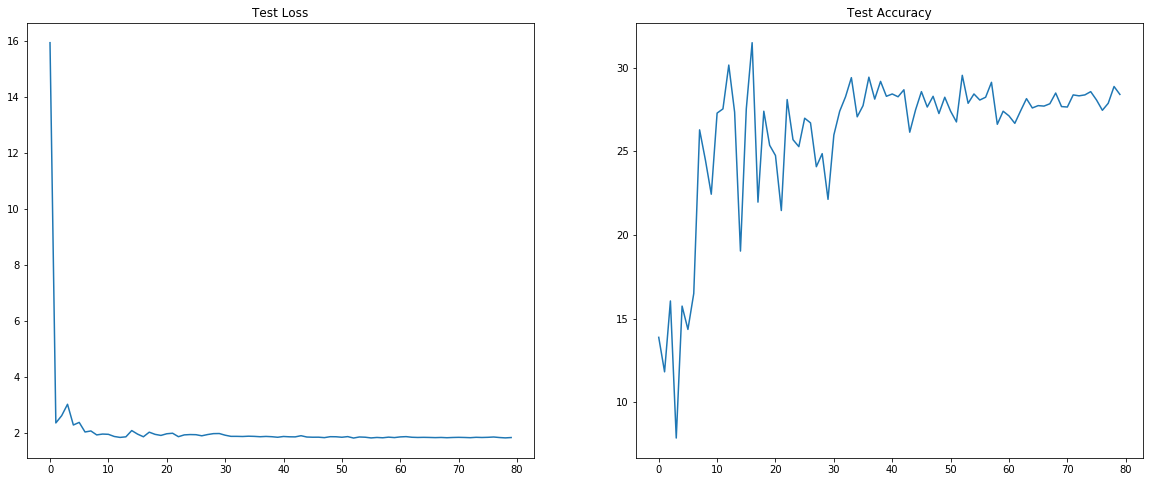

In [13]:
for epoch in range(50, 80):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer, loss_func, mining_func, scheduler)
    tloss = test(model, validation_generator)
    scheduler.step(tloss)
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

  0%|          | 0/225 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.004 


Loss=0.10281665623188019 Batch_id=224 le=0.004 Accuracy=14.62: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.1306976122133676  | train_acc:  tensor(0.1462, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 36.7862, Accuracy: 467.0/3589 (13.01%)

* Update optimal model
EPOCH: 1 LR: 0.004 


Loss=0.10337349027395248 Batch_id=224 le=0.004 Accuracy=14.32: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10290128904456085  | train_acc:  tensor(0.1432, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 14.3223, Accuracy: 653.0/3589 (18.19%)

* Update optimal model
EPOCH: 2 LR: 0.004 


Loss=0.10352828353643417 Batch_id=224 le=0.004 Accuracy=14.43: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10274806151423418  | train_acc:  tensor(0.1443, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 12.8690, Accuracy: 467.0/3589 (13.01%)

* Update optimal model
EPOCH: 3 LR: 0.004 


Loss=0.1024245098233223 Batch_id=224 le=0.004 Accuracy=14.09: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s] 

	 train_loss:  0.10268225471592193  | train_acc:  tensor(0.1409, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 23.0022, Accuracy: 467.0/3589 (13.01%)

* Update optimal model
EPOCH: 4 LR: 0.004 


Loss=0.0998099148273468 Batch_id=224 le=0.004 Accuracy=14.88: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s] 

	 train_loss:  0.10288917130676364  | train_acc:  tensor(0.1488, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 31.1515, Accuracy: 467.0/3589 (13.01%)

* Update optimal model
EPOCH: 5 LR: 0.004 


Loss=0.10026725381612778 Batch_id=224 le=0.004 Accuracy=14.65: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10322288412098193  | train_acc:  tensor(0.1465, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.9376, Accuracy: 875.0/3589 (24.38%)

* Update optimal model
EPOCH: 6 LR: 0.004 


Loss=0.10588030517101288 Batch_id=224 le=0.004 Accuracy=14.24: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10271324385177495  | train_acc:  tensor(0.1424, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 5.1769, Accuracy: 807.0/3589 (22.49%)

* Update optimal model
EPOCH: 7 LR: 0.004 


Loss=0.1017967015504837 Batch_id=224 le=0.004 Accuracy=14.93: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s] 

	 train_loss:  0.10264739744385198  | train_acc:  tensor(0.1493, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 14.8943, Accuracy: 512.0/3589 (14.27%)

* Update optimal model
EPOCH: 8 LR: 0.004 


Loss=0.10243064910173416 Batch_id=224 le=0.004 Accuracy=14.70: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10280244741671228  | train_acc:  tensor(0.1470, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 4.2000, Accuracy: 741.0/3589 (20.65%)

* Update optimal model
EPOCH: 9 LR: 0.004 


Loss=0.1005188450217247 Batch_id=224 le=0.004 Accuracy=14.55: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s] 

	 train_loss:  0.10300905877458476  | train_acc:  tensor(0.1455, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.1293, Accuracy: 405.0/3589 (11.28%)

* Update optimal model
EPOCH: 10 LR: 0.004 


Loss=0.10464949905872345 Batch_id=224 le=0.004 Accuracy=13.92: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10278644603841079  | train_acc:  tensor(0.1392, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 16.9010, Accuracy: 336.0/3589 (9.36%)

* Update optimal model
EPOCH: 11 LR: 0.004 


Loss=0.10413125902414322 Batch_id=224 le=0.004 Accuracy=15.05: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.102732550589884  | train_acc:  tensor(0.1505, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 5.3303, Accuracy: 340.0/3589 (9.47%)

* Update optimal model
EPOCH: 12 LR: 0.004 


Loss=0.10191679000854492 Batch_id=224 le=0.004 Accuracy=14.32: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

	 train_loss:  0.10300019748316626  | train_acc:  tensor(0.1432, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.6161, Accuracy: 830.0/3589 (23.13%)

* Update optimal model
EPOCH: 13 LR: 0.004 


Loss=0.10234130918979645 Batch_id=224 le=0.004 Accuracy=14.24: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10316391024107785  | train_acc:  tensor(0.1424, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 7.9227, Accuracy: 535.0/3589 (14.91%)

* Update optimal model
EPOCH: 14 LR: 0.004 


Loss=0.10466276854276657 Batch_id=224 le=0.004 Accuracy=14.28: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10307144453795321  | train_acc:  tensor(0.1428, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 7.0320, Accuracy: 513.0/3589 (14.29%)

* Update optimal model
EPOCH: 15 LR: 0.004 


Loss=0.09926658868789673 Batch_id=224 le=0.004 Accuracy=15.47: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.1028133745917482  | train_acc:  tensor(0.1547, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 6.3505, Accuracy: 824.0/3589 (22.96%)

* Update optimal model
EPOCH: 16 LR: 0.004 


Loss=0.10510971397161484 Batch_id=224 le=0.004 Accuracy=14.65: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10296264385768265  | train_acc:  tensor(0.1465, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 12.0263, Accuracy: 615.0/3589 (17.14%)

* Update optimal model
EPOCH: 17 LR: 0.004 


Loss=0.1045287549495697 Batch_id=224 le=0.004 Accuracy=14.04: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s] 

	 train_loss:  0.10315152569650761  | train_acc:  tensor(0.1404, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0466, Accuracy: 891.0/3589 (24.83%)

* Update optimal model
EPOCH: 18 LR: 0.004 


Loss=0.10186255723237991 Batch_id=224 le=0.004 Accuracy=13.80: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10308204558444889  | train_acc:  tensor(0.1380, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 8.3438, Accuracy: 335.0/3589 (9.33%)

* Update optimal model
EPOCH: 19 LR: 0.002 


Loss=0.10530345886945724 Batch_id=224 le=0.002 Accuracy=13.89: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10258408779836821  | train_acc:  tensor(0.1389, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0899, Accuracy: 739.0/3589 (20.59%)

* Update optimal model
EPOCH: 20 LR: 0.002 


Loss=0.10545715689659119 Batch_id=224 le=0.002 Accuracy=14.26: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10285130907817464  | train_acc:  tensor(0.1426, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.7299, Accuracy: 593.0/3589 (16.52%)

* Update optimal model
EPOCH: 21 LR: 0.002 


Loss=0.10377068817615509 Batch_id=224 le=0.002 Accuracy=14.90: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10249571268121012  | train_acc:  tensor(0.1490, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.8266, Accuracy: 630.0/3589 (17.55%)

* Update optimal model
EPOCH: 22 LR: 0.002 


Loss=0.1064118966460228 Batch_id=224 le=0.002 Accuracy=15.24: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s] 

	 train_loss:  0.10268396846261027  | train_acc:  tensor(0.1524, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.2235, Accuracy: 752.0/3589 (20.95%)

* Update optimal model
EPOCH: 23 LR: 0.002 


Loss=0.10413996875286102 Batch_id=224 le=0.002 Accuracy=16.58: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10309820693911312  | train_acc:  tensor(0.1658, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.4736, Accuracy: 765.0/3589 (21.32%)

* Update optimal model
EPOCH: 24 LR: 0.002 


Loss=0.10378624498844147 Batch_id=224 le=0.002 Accuracy=16.35: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.1034331663479156  | train_acc:  tensor(0.1635, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.3851, Accuracy: 503.0/3589 (14.02%)

* Update optimal model
EPOCH: 25 LR: 0.002 


Loss=0.10438913106918335 Batch_id=224 le=0.002 Accuracy=15.95: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10311700291110246  | train_acc:  tensor(0.1595, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.4523, Accuracy: 511.0/3589 (14.24%)

* Update optimal model
EPOCH: 26 LR: 0.002 


Loss=0.10553934425115585 Batch_id=224 le=0.002 Accuracy=15.31: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10331414067576832  | train_acc:  tensor(0.1531, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0027, Accuracy: 639.0/3589 (17.80%)

* Update optimal model
EPOCH: 27 LR: 0.002 


Loss=0.10003548115491867 Batch_id=224 le=0.002 Accuracy=14.88: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10328434852347894  | train_acc:  tensor(0.1488, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0941, Accuracy: 577.0/3589 (16.08%)

* Update optimal model
EPOCH: 28 LR: 0.001 


Loss=0.10427917540073395 Batch_id=224 le=0.001 Accuracy=16.40: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10325550708982438  | train_acc:  tensor(0.1640, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.2605, Accuracy: 691.0/3589 (19.25%)

* Update optimal model
EPOCH: 29 LR: 0.001 


Loss=0.10663777589797974 Batch_id=224 le=0.001 Accuracy=16.01: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10367682034404031  | train_acc:  tensor(0.1601, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.3420, Accuracy: 547.0/3589 (15.24%)

* Update optimal model
EPOCH: 30 LR: 0.001 


Loss=0.10769184678792953 Batch_id=224 le=0.001 Accuracy=14.32: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10401800498322238  | train_acc:  tensor(0.1432, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.5673, Accuracy: 526.0/3589 (14.66%)

* Update optimal model
EPOCH: 31 LR: 0.001 


Loss=0.10606452077627182 Batch_id=224 le=0.001 Accuracy=12.08: 100%|██████████| 225/225 [00:32<00:00,  6.96it/s]

	 train_loss:  0.10411787178594327  | train_acc:  tensor(0.1208, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.1674, Accuracy: 353.0/3589 (9.84%)

* Update optimal model
EPOCH: 32 LR: 0.001 


Loss=0.10303939878940582 Batch_id=224 le=0.001 Accuracy=10.69: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10432731872984075  | train_acc:  tensor(0.1069, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.8384, Accuracy: 303.0/3589 (8.44%)

* Update optimal model
EPOCH: 33 LR: 0.001 


Loss=0.11286552250385284 Batch_id=224 le=0.001 Accuracy=9.98: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s] 

	 train_loss:  0.10455705907488157  | train_acc:  tensor(0.0998, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.2251, Accuracy: 283.0/3589 (7.89%)

* Update optimal model
EPOCH: 34 LR: 0.001 


Loss=0.10577011853456497 Batch_id=224 le=0.001 Accuracy=9.77: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.1044331114898655  | train_acc:  tensor(0.0977, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.4297, Accuracy: 501.0/3589 (13.96%)

* Update optimal model
EPOCH: 35 LR: 0.001 


Loss=0.09558910876512527 Batch_id=224 le=0.001 Accuracy=9.33: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10469948762458853  | train_acc:  tensor(0.0933, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.8255, Accuracy: 243.0/3589 (6.77%)

* Update optimal model
EPOCH: 36 LR: 0.001 


Loss=0.11058730632066727 Batch_id=224 le=0.001 Accuracy=9.71: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10494852291018558  | train_acc:  tensor(0.0971, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.7268, Accuracy: 273.0/3589 (7.61%)

* Update optimal model
EPOCH: 37 LR: 0.0005 


Loss=0.10542421787977219 Batch_id=224 le=0.0005 Accuracy=9.25: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10483989093966932  | train_acc:  tensor(0.0925, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0423, Accuracy: 234.0/3589 (6.52%)

* Update optimal model
EPOCH: 38 LR: 0.0005 


Loss=0.09833942353725433 Batch_id=224 le=0.0005 Accuracy=8.65: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]

	 train_loss:  0.10499078311847998  | train_acc:  tensor(0.0865, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.9689, Accuracy: 232.0/3589 (6.46%)

* Update optimal model
EPOCH: 39 LR: 0.0005 


Loss=0.10371039062738419 Batch_id=224 le=0.0005 Accuracy=8.20: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10453542843297539  | train_acc:  tensor(0.0820, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0205, Accuracy: 193.0/3589 (5.38%)

* Update optimal model
EPOCH: 40 LR: 0.0005 


Loss=0.10151366889476776 Batch_id=224 le=0.0005 Accuracy=8.65: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10504523706781216  | train_acc:  tensor(0.0865, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.7655, Accuracy: 213.0/3589 (5.93%)

* Update optimal model
EPOCH: 41 LR: 0.0005 


Loss=0.10823556780815125 Batch_id=224 le=0.0005 Accuracy=8.43: 100%|██████████| 225/225 [00:32<00:00,  6.95it/s]

	 train_loss:  0.10520712706527723  | train_acc:  tensor(0.0843, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.7220, Accuracy: 183.0/3589 (5.10%)

* Update optimal model
EPOCH: 42 LR: 0.0005 


Loss=0.09449998289346695 Batch_id=224 le=0.0005 Accuracy=8.36: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10515682137546264  | train_acc:  tensor(0.0836, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.8803, Accuracy: 195.0/3589 (5.43%)

* Update optimal model
EPOCH: 43 LR: 0.0005 


Loss=0.10292663425207138 Batch_id=224 le=0.0005 Accuracy=7.86: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10520490412776001  | train_acc:  tensor(0.0786, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.7913, Accuracy: 202.0/3589 (5.63%)

* Update optimal model
EPOCH: 44 LR: 0.0005 


Loss=0.10126722604036331 Batch_id=224 le=0.0005 Accuracy=7.67: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]

	 train_loss:  0.10521834248220074  | train_acc:  tensor(0.0767, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.7833, Accuracy: 211.0/3589 (5.88%)

* Update optimal model
EPOCH: 45 LR: 0.0005 


Loss=0.11047065258026123 Batch_id=224 le=0.0005 Accuracy=7.83: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10522400942536049  | train_acc:  tensor(0.0783, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.9556, Accuracy: 181.0/3589 (5.04%)

* Update optimal model
EPOCH: 46 LR: 0.00025 


Loss=0.10586902499198914 Batch_id=224 le=0.00025 Accuracy=7.40: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

	 train_loss:  0.10524991410246728  | train_acc:  tensor(0.0740, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 3.0089, Accuracy: 179.0/3589 (4.99%)

* Update optimal model
EPOCH: 47 LR: 0.00025 


Loss=0.09991156309843063 Batch_id=224 le=0.00025 Accuracy=7.42: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]

	 train_loss:  0.10511844508665733  | train_acc:  tensor(0.0742, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.8472, Accuracy: 182.0/3589 (5.07%)

* Update optimal model
EPOCH: 48 LR: 0.00025 


Loss=0.1101573258638382 Batch_id=224 le=0.00025 Accuracy=7.69: 100%|██████████| 225/225 [00:32<00:00,  6.92it/s] 

	 train_loss:  0.10540124322361215  | train_acc:  tensor(0.0769, device='cuda:0')



  0%|          | 0/225 [00:00<?, ?it/s]


Test set: Average loss: 2.8421, Accuracy: 193.0/3589 (5.38%)

* Update optimal model
EPOCH: 49 LR: 0.00025 


Loss=0.11410798132419586 Batch_id=224 le=0.00025 Accuracy=7.14: 100%|██████████| 225/225 [00:32<00:00,  6.93it/s]

	 train_loss:  0.10544108101949078  | train_acc:  tensor(0.0714, device='cuda:0')



Test set: Average loss: 2.7746, Accuracy: 191.0/3589 (5.32%)

* Update optimal model


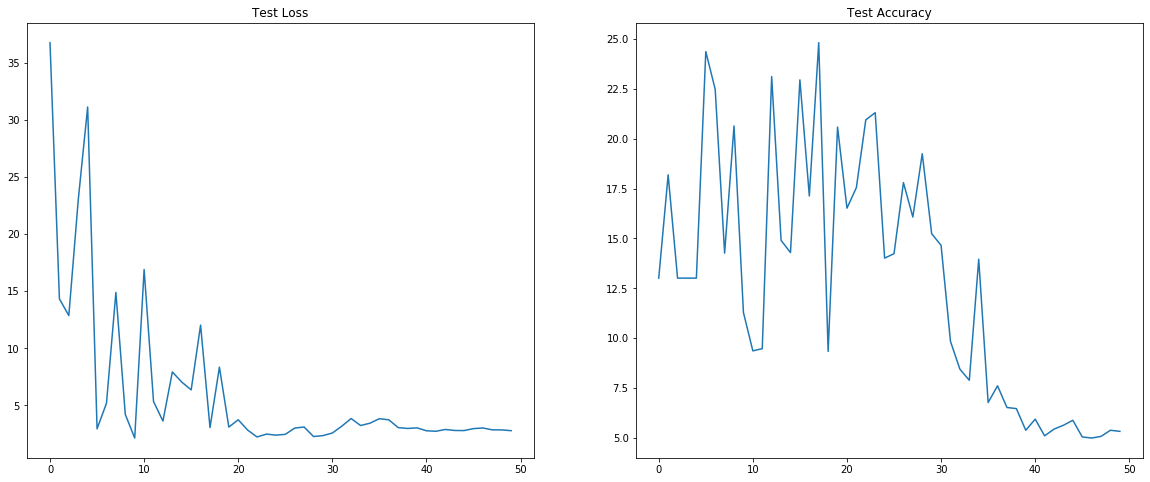

In [18]:
model_path = None
device = torch.device('cuda')
model=VGG16_baseline(pretrained=False)
model.to(device)
epochs=50
optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=9e-4)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=False)

input_size=(3,48,48)
model_path = None
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer, loss_func, mining_func, scheduler)
    tloss = test(model, validation_generator)
    scheduler.step(tloss)
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

In [20]:
len(training_generator) * batch_size

28800

In [10]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                np.squeeze(test_labels),
                                                np.squeeze(train_labels),
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

In [11]:
num_epochs = 50

model_path = None
device = torch.device('cuda')
model=SVGG(device=device)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=num_epochs)


### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)
### pytorch-metric-learning stuff ###


for epoch in range(1, num_epochs+1):
    train(model, loss_func, mining_func, device, training_generator, optimizer, epoch)
    test(training_set, val_set, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.10073044896125793, Number of mined triplets = 40281
Epoch 1 Iteration 20: Loss = 0.10345745831727982, Number of mined triplets = 29278
Epoch 1 Iteration 40: Loss = 0.10296853631734848, Number of mined triplets = 28032
Epoch 1 Iteration 60: Loss = 0.10440747439861298, Number of mined triplets = 28589
Epoch 1 Iteration 80: Loss = 0.1031470075249672, Number of mined triplets = 27813
Epoch 1 Iteration 100: Loss = 0.10352851450443268, Number of mined triplets = 28453
Epoch 1 Iteration 120: Loss = 0.10261863470077515, Number of mined triplets = 29101
Epoch 1 Iteration 140: Loss = 0.10224378108978271, Number of mined triplets = 27799
Epoch 1 Iteration 160: Loss = 0.1050860583782196, Number of mined triplets = 31528
Epoch 1 Iteration 180: Loss = 0.10431153327226639, Number of mined triplets = 31115
Epoch 1 Iteration 200: Loss = 0.10295065492391586, Number of mined triplets = 28950
Epoch 1 Iteration 220: Loss = 0.10284732282161713, Number of mined triplets = 26531


100%|██████████| 113/113 [00:04<00:00, 24.68it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.2599609919197548


Epoch 2 Iteration 0: Loss = 0.10411224514245987, Number of mined triplets = 30155
Epoch 2 Iteration 20: Loss = 0.10393738001585007, Number of mined triplets = 29476
Epoch 2 Iteration 40: Loss = 0.10315094143152237, Number of mined triplets = 27378
Epoch 2 Iteration 60: Loss = 0.10845015943050385, Number of mined triplets = 30482
Epoch 2 Iteration 80: Loss = 0.10306336730718613, Number of mined triplets = 29848
Epoch 2 Iteration 100: Loss = 0.10736926645040512, Number of mined triplets = 31241
Epoch 2 Iteration 120: Loss = 0.10658872872591019, Number of mined triplets = 28277
Epoch 2 Iteration 140: Loss = 0.10276743769645691, Number of mined triplets = 28399
Epoch 2 Iteration 160: Loss = 0.10480990260839462, Number of mined triplets = 28510
Epoch 2 Iteration 180: Loss = 0.10750783979892731, Number of mined triplets = 28965
Epoch 2 Iteration 200: Loss = 0.10344512015581131, Number of mined triplets = 28261
Epoch 2 Iteration 220: Loss = 0.10448983311653137, Number of mined triplets = 2903

100%|██████████| 113/113 [00:04<00:00, 24.48it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.27667874059626635


Epoch 3 Iteration 0: Loss = 0.10481922328472137, Number of mined triplets = 28107
Epoch 3 Iteration 20: Loss = 0.11201946437358856, Number of mined triplets = 29479
Epoch 3 Iteration 40: Loss = 0.1050560399889946, Number of mined triplets = 27665
Epoch 3 Iteration 60: Loss = 0.10827352106571198, Number of mined triplets = 31337
Epoch 3 Iteration 80: Loss = 0.10876963287591934, Number of mined triplets = 32845
Epoch 3 Iteration 100: Loss = 0.10414702445268631, Number of mined triplets = 28595
Epoch 3 Iteration 120: Loss = 0.10774131864309311, Number of mined triplets = 30521
Epoch 3 Iteration 140: Loss = 0.10694890469312668, Number of mined triplets = 29499
Epoch 3 Iteration 160: Loss = 0.10478280484676361, Number of mined triplets = 27158
Epoch 3 Iteration 180: Loss = 0.10401248186826706, Number of mined triplets = 30013
Epoch 3 Iteration 200: Loss = 0.10509099066257477, Number of mined triplets = 29321
Epoch 3 Iteration 220: Loss = 0.10496843606233597, Number of mined triplets = 27649

100%|██████████| 113/113 [00:04<00:00, 24.52it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.31290052939537477


Epoch 4 Iteration 0: Loss = 0.10630534589290619, Number of mined triplets = 29144
Epoch 4 Iteration 20: Loss = 0.10608930140733719, Number of mined triplets = 27472
Epoch 4 Iteration 40: Loss = 0.10868777334690094, Number of mined triplets = 31015
Epoch 4 Iteration 60: Loss = 0.10550976544618607, Number of mined triplets = 26994
Epoch 4 Iteration 80: Loss = 0.10799947381019592, Number of mined triplets = 29700
Epoch 4 Iteration 100: Loss = 0.10389776527881622, Number of mined triplets = 28612
Epoch 4 Iteration 120: Loss = 0.1065574511885643, Number of mined triplets = 28430
Epoch 4 Iteration 140: Loss = 0.105307936668396, Number of mined triplets = 28476
Epoch 4 Iteration 160: Loss = 0.10994773358106613, Number of mined triplets = 31083
Epoch 4 Iteration 180: Loss = 0.10771879553794861, Number of mined triplets = 28366
Epoch 4 Iteration 200: Loss = 0.10651686042547226, Number of mined triplets = 27896
Epoch 4 Iteration 220: Loss = 0.10369844734668732, Number of mined triplets = 28786


100%|██████████| 113/113 [00:04<00:00, 24.56it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.30064084703259963


Epoch 5 Iteration 0: Loss = 0.1017010360956192, Number of mined triplets = 25695
Epoch 5 Iteration 20: Loss = 0.10333104431629181, Number of mined triplets = 28051
Epoch 5 Iteration 40: Loss = 0.10439514368772507, Number of mined triplets = 28002
Epoch 5 Iteration 60: Loss = 0.10808195173740387, Number of mined triplets = 30335
Epoch 5 Iteration 80: Loss = 0.10293007642030716, Number of mined triplets = 28065
Epoch 5 Iteration 100: Loss = 0.10349025577306747, Number of mined triplets = 27636
Epoch 5 Iteration 120: Loss = 0.1014351025223732, Number of mined triplets = 25994
Epoch 5 Iteration 140: Loss = 0.10285282880067825, Number of mined triplets = 27115
Epoch 5 Iteration 160: Loss = 0.10360487550497055, Number of mined triplets = 28251
Epoch 5 Iteration 180: Loss = 0.1028059646487236, Number of mined triplets = 26937
Epoch 5 Iteration 200: Loss = 0.10223527252674103, Number of mined triplets = 26876
Epoch 5 Iteration 220: Loss = 0.1085902601480484, Number of mined triplets = 30109


100%|██████████| 113/113 [00:04<00:00, 24.23it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.352744497074394


Epoch 6 Iteration 0: Loss = 0.10559428483247757, Number of mined triplets = 25579
Epoch 6 Iteration 20: Loss = 0.1032031923532486, Number of mined triplets = 28401
Epoch 6 Iteration 40: Loss = 0.10316789150238037, Number of mined triplets = 29903
Epoch 6 Iteration 60: Loss = 0.1025937870144844, Number of mined triplets = 26605
Epoch 6 Iteration 80: Loss = 0.10340200364589691, Number of mined triplets = 26951
Epoch 6 Iteration 100: Loss = 0.10346250236034393, Number of mined triplets = 28594
Epoch 6 Iteration 120: Loss = 0.10803454369306564, Number of mined triplets = 28378
Epoch 6 Iteration 140: Loss = 0.10208826512098312, Number of mined triplets = 24688
Epoch 6 Iteration 160: Loss = 0.10228793323040009, Number of mined triplets = 25616
Epoch 6 Iteration 180: Loss = 0.10286716371774673, Number of mined triplets = 25826
Epoch 6 Iteration 200: Loss = 0.10738637298345566, Number of mined triplets = 24307
Epoch 6 Iteration 220: Loss = 0.10150197893381119, Number of mined triplets = 25742


100%|██████████| 113/113 [00:04<00:00, 24.36it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.3482864307606576


Epoch 7 Iteration 0: Loss = 0.10688958317041397, Number of mined triplets = 26130
Epoch 7 Iteration 20: Loss = 0.10306625068187714, Number of mined triplets = 26479
Epoch 7 Iteration 40: Loss = 0.10656025260686874, Number of mined triplets = 27287
Epoch 7 Iteration 60: Loss = 0.10348093509674072, Number of mined triplets = 27574
Epoch 7 Iteration 80: Loss = 0.10229725390672684, Number of mined triplets = 23956
Epoch 7 Iteration 100: Loss = 0.1036083921790123, Number of mined triplets = 26105
Epoch 7 Iteration 120: Loss = 0.1025208830833435, Number of mined triplets = 26893
Epoch 7 Iteration 140: Loss = 0.10413187742233276, Number of mined triplets = 28236
Epoch 7 Iteration 160: Loss = 0.10324626415967941, Number of mined triplets = 25746
Epoch 7 Iteration 180: Loss = 0.10184013098478317, Number of mined triplets = 25336
Epoch 7 Iteration 200: Loss = 0.10033819079399109, Number of mined triplets = 26079
Epoch 7 Iteration 220: Loss = 0.102936290204525, Number of mined triplets = 25112


100%|██████████| 113/113 [00:04<00:00, 24.42it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.3661186960156032


Epoch 8 Iteration 0: Loss = 0.10475250333547592, Number of mined triplets = 26493
Epoch 8 Iteration 20: Loss = 0.10492783784866333, Number of mined triplets = 30275
Epoch 8 Iteration 40: Loss = 0.1045386865735054, Number of mined triplets = 26315
Epoch 8 Iteration 60: Loss = 0.10794617235660553, Number of mined triplets = 25377
Epoch 8 Iteration 80: Loss = 0.1034066453576088, Number of mined triplets = 27593
Epoch 8 Iteration 100: Loss = 0.09887450188398361, Number of mined triplets = 23027
Epoch 8 Iteration 120: Loss = 0.1031036525964737, Number of mined triplets = 26410
Epoch 8 Iteration 140: Loss = 0.10628554970026016, Number of mined triplets = 27618
Epoch 8 Iteration 160: Loss = 0.10580827295780182, Number of mined triplets = 28424
Epoch 8 Iteration 180: Loss = 0.10363779217004776, Number of mined triplets = 26254
Epoch 8 Iteration 200: Loss = 0.10328304767608643, Number of mined triplets = 26069
Epoch 8 Iteration 220: Loss = 0.10787425935268402, Number of mined triplets = 25109


100%|██████████| 113/113 [00:04<00:00, 24.59it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.3842295904151574


Epoch 9 Iteration 0: Loss = 0.1034976989030838, Number of mined triplets = 23112
Epoch 9 Iteration 20: Loss = 0.10640302300453186, Number of mined triplets = 25280
Epoch 9 Iteration 40: Loss = 0.10233288258314133, Number of mined triplets = 23299
Epoch 9 Iteration 60: Loss = 0.10414312779903412, Number of mined triplets = 26847
Epoch 9 Iteration 80: Loss = 0.10142993181943893, Number of mined triplets = 24350
Epoch 9 Iteration 100: Loss = 0.10220586508512497, Number of mined triplets = 25519
Epoch 9 Iteration 120: Loss = 0.1026085913181305, Number of mined triplets = 25103
Epoch 9 Iteration 140: Loss = 0.1036527082324028, Number of mined triplets = 24813
Epoch 9 Iteration 160: Loss = 0.10818110406398773, Number of mined triplets = 27673
Epoch 9 Iteration 180: Loss = 0.10184545069932938, Number of mined triplets = 24539
Epoch 9 Iteration 200: Loss = 0.10297568887472153, Number of mined triplets = 26476
Epoch 9 Iteration 220: Loss = 0.10405406355857849, Number of mined triplets = 27287


100%|██████████| 113/113 [00:04<00:00, 24.35it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.3900808024519365


Epoch 10 Iteration 0: Loss = 0.10333273559808731, Number of mined triplets = 28599
Epoch 10 Iteration 20: Loss = 0.10644292086362839, Number of mined triplets = 24516
Epoch 10 Iteration 40: Loss = 0.10590802133083344, Number of mined triplets = 26623
Epoch 10 Iteration 60: Loss = 0.10629993677139282, Number of mined triplets = 27160
Epoch 10 Iteration 80: Loss = 0.10315486788749695, Number of mined triplets = 24220
Epoch 10 Iteration 100: Loss = 0.1030767634510994, Number of mined triplets = 26531
Epoch 10 Iteration 120: Loss = 0.10109985619783401, Number of mined triplets = 25658
Epoch 10 Iteration 140: Loss = 0.10212759673595428, Number of mined triplets = 25971
Epoch 10 Iteration 160: Loss = 0.10303130745887756, Number of mined triplets = 23864
Epoch 10 Iteration 180: Loss = 0.10284964740276337, Number of mined triplets = 25676
Epoch 10 Iteration 200: Loss = 0.10182906687259674, Number of mined triplets = 24142
Epoch 10 Iteration 220: Loss = 0.10418803989887238, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.22it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.3786570075229869


Epoch 11 Iteration 0: Loss = 0.10827585309743881, Number of mined triplets = 26782
Epoch 11 Iteration 20: Loss = 0.10344484448432922, Number of mined triplets = 26546
Epoch 11 Iteration 40: Loss = 0.1046060100197792, Number of mined triplets = 26017
Epoch 11 Iteration 60: Loss = 0.10133369266986847, Number of mined triplets = 31377
Epoch 11 Iteration 80: Loss = 0.10294608026742935, Number of mined triplets = 25234
Epoch 11 Iteration 100: Loss = 0.10111089795827866, Number of mined triplets = 23497
Epoch 11 Iteration 120: Loss = 0.10454592853784561, Number of mined triplets = 28314
Epoch 11 Iteration 140: Loss = 0.10464677959680557, Number of mined triplets = 26883
Epoch 11 Iteration 160: Loss = 0.1055377945303917, Number of mined triplets = 24939
Epoch 11 Iteration 180: Loss = 0.10962225496768951, Number of mined triplets = 26533
Epoch 11 Iteration 200: Loss = 0.1019827276468277, Number of mined triplets = 23965
Epoch 11 Iteration 220: Loss = 0.10462777316570282, Number of mined triple

100%|██████████| 113/113 [00:04<00:00, 24.62it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.38032878239063805


Epoch 12 Iteration 0: Loss = 0.10384072363376617, Number of mined triplets = 27472
Epoch 12 Iteration 20: Loss = 0.10329118371009827, Number of mined triplets = 22026
Epoch 12 Iteration 40: Loss = 0.1031746119260788, Number of mined triplets = 28001
Epoch 12 Iteration 60: Loss = 0.10713241249322891, Number of mined triplets = 26599
Epoch 12 Iteration 80: Loss = 0.10450214892625809, Number of mined triplets = 23621
Epoch 12 Iteration 100: Loss = 0.10429427027702332, Number of mined triplets = 27838
Epoch 12 Iteration 120: Loss = 0.10164427012205124, Number of mined triplets = 23704
Epoch 12 Iteration 140: Loss = 0.10083373636007309, Number of mined triplets = 23230
Epoch 12 Iteration 160: Loss = 0.1032588928937912, Number of mined triplets = 26764
Epoch 12 Iteration 180: Loss = 0.10282310098409653, Number of mined triplets = 25373
Epoch 12 Iteration 200: Loss = 0.10489025712013245, Number of mined triplets = 26787
Epoch 12 Iteration 220: Loss = 0.10166893154382706, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.33it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4087489551407077


Epoch 13 Iteration 0: Loss = 0.0988006666302681, Number of mined triplets = 23195
Epoch 13 Iteration 20: Loss = 0.10482782125473022, Number of mined triplets = 26501
Epoch 13 Iteration 40: Loss = 0.10570817440748215, Number of mined triplets = 26684
Epoch 13 Iteration 60: Loss = 0.10468234866857529, Number of mined triplets = 24457
Epoch 13 Iteration 80: Loss = 0.10344616323709488, Number of mined triplets = 24328
Epoch 13 Iteration 100: Loss = 0.10297238081693649, Number of mined triplets = 23322
Epoch 13 Iteration 120: Loss = 0.10130675137042999, Number of mined triplets = 23852
Epoch 13 Iteration 140: Loss = 0.10367569327354431, Number of mined triplets = 24301
Epoch 13 Iteration 160: Loss = 0.10545935481786728, Number of mined triplets = 24348
Epoch 13 Iteration 180: Loss = 0.10659221559762955, Number of mined triplets = 25805
Epoch 13 Iteration 200: Loss = 0.10517635196447372, Number of mined triplets = 25151
Epoch 13 Iteration 220: Loss = 0.10581810027360916, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.43it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.422123154081917


Epoch 14 Iteration 0: Loss = 0.10116039216518402, Number of mined triplets = 23675
Epoch 14 Iteration 20: Loss = 0.10518299788236618, Number of mined triplets = 26946
Epoch 14 Iteration 40: Loss = 0.10410019010305405, Number of mined triplets = 26783
Epoch 14 Iteration 60: Loss = 0.10447569936513901, Number of mined triplets = 23331
Epoch 14 Iteration 80: Loss = 0.10216090083122253, Number of mined triplets = 25539
Epoch 14 Iteration 100: Loss = 0.1029210090637207, Number of mined triplets = 22642
Epoch 14 Iteration 120: Loss = 0.10402553528547287, Number of mined triplets = 25444
Epoch 14 Iteration 140: Loss = 0.10263676196336746, Number of mined triplets = 25554
Epoch 14 Iteration 160: Loss = 0.1043785810470581, Number of mined triplets = 24379
Epoch 14 Iteration 180: Loss = 0.10531891137361526, Number of mined triplets = 23341
Epoch 14 Iteration 200: Loss = 0.10206497460603714, Number of mined triplets = 26445
Epoch 14 Iteration 220: Loss = 0.10222180932760239, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.37it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.38200055725828924


Epoch 15 Iteration 0: Loss = 0.10454823076725006, Number of mined triplets = 24527
Epoch 15 Iteration 20: Loss = 0.1046580970287323, Number of mined triplets = 24717
Epoch 15 Iteration 40: Loss = 0.10173874348402023, Number of mined triplets = 24746
Epoch 15 Iteration 60: Loss = 0.10238799452781677, Number of mined triplets = 24315
Epoch 15 Iteration 80: Loss = 0.10184124112129211, Number of mined triplets = 25006
Epoch 15 Iteration 100: Loss = 0.10360558331012726, Number of mined triplets = 23963
Epoch 15 Iteration 120: Loss = 0.10197507590055466, Number of mined triplets = 22516
Epoch 15 Iteration 140: Loss = 0.10305210202932358, Number of mined triplets = 22346
Epoch 15 Iteration 160: Loss = 0.10471804440021515, Number of mined triplets = 23861
Epoch 15 Iteration 180: Loss = 0.10409597307443619, Number of mined triplets = 24184
Epoch 15 Iteration 200: Loss = 0.10177262872457504, Number of mined triplets = 24254
Epoch 15 Iteration 220: Loss = 0.10363008826971054, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.56it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.42630259125104486


Epoch 16 Iteration 0: Loss = 0.10643845051527023, Number of mined triplets = 25983
Epoch 16 Iteration 20: Loss = 0.10388367623090744, Number of mined triplets = 24176
Epoch 16 Iteration 40: Loss = 0.10194907337427139, Number of mined triplets = 25101
Epoch 16 Iteration 60: Loss = 0.10059952735900879, Number of mined triplets = 22715
Epoch 16 Iteration 80: Loss = 0.10447641462087631, Number of mined triplets = 23419
Epoch 16 Iteration 100: Loss = 0.1047058254480362, Number of mined triplets = 22142
Epoch 16 Iteration 120: Loss = 0.10165049880743027, Number of mined triplets = 25413
Epoch 16 Iteration 140: Loss = 0.10264769196510315, Number of mined triplets = 23303
Epoch 16 Iteration 160: Loss = 0.10215484350919724, Number of mined triplets = 24466
Epoch 16 Iteration 180: Loss = 0.10557127743959427, Number of mined triplets = 27262
Epoch 16 Iteration 200: Loss = 0.1030452623963356, Number of mined triplets = 24762
Epoch 16 Iteration 220: Loss = 0.10448865592479706, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.55it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4257453329618278


Epoch 17 Iteration 0: Loss = 0.10451602190732956, Number of mined triplets = 27793
Epoch 17 Iteration 20: Loss = 0.10420989990234375, Number of mined triplets = 24014
Epoch 17 Iteration 40: Loss = 0.1038336381316185, Number of mined triplets = 23429
Epoch 17 Iteration 60: Loss = 0.10420327633619308, Number of mined triplets = 25975
Epoch 17 Iteration 80: Loss = 0.10450654476881027, Number of mined triplets = 21351
Epoch 17 Iteration 100: Loss = 0.1048816666007042, Number of mined triplets = 24264
Epoch 17 Iteration 120: Loss = 0.10420231521129608, Number of mined triplets = 22882
Epoch 17 Iteration 140: Loss = 0.1042814701795578, Number of mined triplets = 25361
Epoch 17 Iteration 160: Loss = 0.10225324332714081, Number of mined triplets = 25559
Epoch 17 Iteration 180: Loss = 0.10306652635335922, Number of mined triplets = 24290
Epoch 17 Iteration 200: Loss = 0.10567079484462738, Number of mined triplets = 25455
Epoch 17 Iteration 220: Loss = 0.10165486484766006, Number of mined triple

100%|██████████| 113/113 [00:04<00:00, 24.39it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4352187238785177


Epoch 18 Iteration 0: Loss = 0.10567847639322281, Number of mined triplets = 23346
Epoch 18 Iteration 20: Loss = 0.10277354717254639, Number of mined triplets = 24705
Epoch 18 Iteration 40: Loss = 0.10249099880456924, Number of mined triplets = 25130
Epoch 18 Iteration 60: Loss = 0.10366757214069366, Number of mined triplets = 26035
Epoch 18 Iteration 80: Loss = 0.10172782838344574, Number of mined triplets = 25703
Epoch 18 Iteration 100: Loss = 0.10332747548818588, Number of mined triplets = 26690
Epoch 18 Iteration 120: Loss = 0.10163237899541855, Number of mined triplets = 26413
Epoch 18 Iteration 140: Loss = 0.10455938428640366, Number of mined triplets = 23282
Epoch 18 Iteration 160: Loss = 0.1050567701458931, Number of mined triplets = 22944
Epoch 18 Iteration 180: Loss = 0.10317271202802658, Number of mined triplets = 23644
Epoch 18 Iteration 200: Loss = 0.10268715769052505, Number of mined triplets = 24120
Epoch 18 Iteration 220: Loss = 0.10158761590719223, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.22it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.42630259125104486


Epoch 19 Iteration 0: Loss = 0.10204968601465225, Number of mined triplets = 23308
Epoch 19 Iteration 20: Loss = 0.10272665321826935, Number of mined triplets = 23394
Epoch 19 Iteration 40: Loss = 0.10478079319000244, Number of mined triplets = 25909
Epoch 19 Iteration 60: Loss = 0.10139282792806625, Number of mined triplets = 27034
Epoch 19 Iteration 80: Loss = 0.10141725838184357, Number of mined triplets = 24556
Epoch 19 Iteration 100: Loss = 0.10180848091840744, Number of mined triplets = 22893
Epoch 19 Iteration 120: Loss = 0.10317615419626236, Number of mined triplets = 23724
Epoch 19 Iteration 140: Loss = 0.1023939996957779, Number of mined triplets = 24753
Epoch 19 Iteration 160: Loss = 0.10357321798801422, Number of mined triplets = 25463
Epoch 19 Iteration 180: Loss = 0.10062377899885178, Number of mined triplets = 21643
Epoch 19 Iteration 200: Loss = 0.10333969444036484, Number of mined triplets = 24312
Epoch 19 Iteration 220: Loss = 0.10181234776973724, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.37it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4416271942045138


Epoch 20 Iteration 0: Loss = 0.10256234556436539, Number of mined triplets = 24234
Epoch 20 Iteration 20: Loss = 0.10082727670669556, Number of mined triplets = 24489
Epoch 20 Iteration 40: Loss = 0.10346917062997818, Number of mined triplets = 23028
Epoch 20 Iteration 60: Loss = 0.10334533452987671, Number of mined triplets = 23451
Epoch 20 Iteration 80: Loss = 0.10096802562475204, Number of mined triplets = 23183
Epoch 20 Iteration 100: Loss = 0.10212405771017075, Number of mined triplets = 24964
Epoch 20 Iteration 120: Loss = 0.09965979307889938, Number of mined triplets = 21311
Epoch 20 Iteration 140: Loss = 0.10184589773416519, Number of mined triplets = 25183
Epoch 20 Iteration 160: Loss = 0.10129037499427795, Number of mined triplets = 25264
Epoch 20 Iteration 180: Loss = 0.10099423676729202, Number of mined triplets = 25348
Epoch 20 Iteration 200: Loss = 0.1039910614490509, Number of mined triplets = 25546
Epoch 20 Iteration 220: Loss = 0.10214421153068542, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.61it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4563945388687657


Epoch 21 Iteration 0: Loss = 0.10299616307020187, Number of mined triplets = 23708
Epoch 21 Iteration 20: Loss = 0.10080724209547043, Number of mined triplets = 23306
Epoch 21 Iteration 40: Loss = 0.10256919264793396, Number of mined triplets = 25690
Epoch 21 Iteration 60: Loss = 0.10174991935491562, Number of mined triplets = 24550
Epoch 21 Iteration 80: Loss = 0.10319709777832031, Number of mined triplets = 21064
Epoch 21 Iteration 100: Loss = 0.10565024614334106, Number of mined triplets = 25598
Epoch 21 Iteration 120: Loss = 0.10242985188961029, Number of mined triplets = 25989
Epoch 21 Iteration 140: Loss = 0.10460089892148972, Number of mined triplets = 26867
Epoch 21 Iteration 160: Loss = 0.10308638215065002, Number of mined triplets = 24437
Epoch 21 Iteration 180: Loss = 0.10315172374248505, Number of mined triplets = 23009
Epoch 21 Iteration 200: Loss = 0.10001393407583237, Number of mined triplets = 24038
Epoch 21 Iteration 220: Loss = 0.10125122219324112, Number of mined tri

100%|██████████| 113/113 [00:04<00:00, 24.42it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.44441348565059907


Epoch 22 Iteration 0: Loss = 0.10327167809009552, Number of mined triplets = 24419
Epoch 22 Iteration 20: Loss = 0.10514155775308609, Number of mined triplets = 23019
Epoch 22 Iteration 40: Loss = 0.10216659307479858, Number of mined triplets = 24361
Epoch 22 Iteration 60: Loss = 0.10507219284772873, Number of mined triplets = 23258
Epoch 22 Iteration 80: Loss = 0.10259617120027542, Number of mined triplets = 26028
Epoch 22 Iteration 100: Loss = 0.10057256370782852, Number of mined triplets = 21488
Epoch 22 Iteration 120: Loss = 0.10297193378210068, Number of mined triplets = 22848
Epoch 22 Iteration 140: Loss = 0.10196057707071304, Number of mined triplets = 25330
Epoch 22 Iteration 160: Loss = 0.10009539872407913, Number of mined triplets = 25340
Epoch 22 Iteration 180: Loss = 0.10563909262418747, Number of mined triplets = 24511
Epoch 22 Iteration 200: Loss = 0.10470806062221527, Number of mined triplets = 24957
Epoch 22 Iteration 220: Loss = 0.10345681756734848, Number of mined tri

100%|██████████| 113/113 [00:04<00:00, 24.50it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4480356645305099


Epoch 23 Iteration 0: Loss = 0.1079532727599144, Number of mined triplets = 23100
Epoch 23 Iteration 20: Loss = 0.10088373720645905, Number of mined triplets = 23213
Epoch 23 Iteration 40: Loss = 0.10033265501260757, Number of mined triplets = 24254
Epoch 23 Iteration 60: Loss = 0.10345514118671417, Number of mined triplets = 23763
Epoch 23 Iteration 80: Loss = 0.1056382805109024, Number of mined triplets = 25145
Epoch 23 Iteration 100: Loss = 0.10134544223546982, Number of mined triplets = 25320
Epoch 23 Iteration 120: Loss = 0.10216498374938965, Number of mined triplets = 22459
Epoch 23 Iteration 140: Loss = 0.10811381042003632, Number of mined triplets = 20587
Epoch 23 Iteration 160: Loss = 0.10327581316232681, Number of mined triplets = 23543
Epoch 23 Iteration 180: Loss = 0.10610354691743851, Number of mined triplets = 26440
Epoch 23 Iteration 200: Loss = 0.10371265560388565, Number of mined triplets = 26513
Epoch 23 Iteration 220: Loss = 0.10166331380605698, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.40it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.44413485650599055


Epoch 24 Iteration 0: Loss = 0.10265326499938965, Number of mined triplets = 20652
Epoch 24 Iteration 20: Loss = 0.10607708990573883, Number of mined triplets = 23259
Epoch 24 Iteration 40: Loss = 0.0996161475777626, Number of mined triplets = 22279
Epoch 24 Iteration 60: Loss = 0.10171688348054886, Number of mined triplets = 21798
Epoch 24 Iteration 80: Loss = 0.10185326635837555, Number of mined triplets = 23116
Epoch 24 Iteration 100: Loss = 0.10087650269269943, Number of mined triplets = 23669
Epoch 24 Iteration 120: Loss = 0.10165812820196152, Number of mined triplets = 24117
Epoch 24 Iteration 140: Loss = 0.10536228865385056, Number of mined triplets = 24293
Epoch 24 Iteration 160: Loss = 0.10714519023895264, Number of mined triplets = 25192
Epoch 24 Iteration 180: Loss = 0.10592739284038544, Number of mined triplets = 21341
Epoch 24 Iteration 200: Loss = 0.10382144153118134, Number of mined triplets = 25782
Epoch 24 Iteration 220: Loss = 0.10125700384378433, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.20it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4488715519643355


Epoch 25 Iteration 0: Loss = 0.10170575231313705, Number of mined triplets = 23625
Epoch 25 Iteration 20: Loss = 0.10286515951156616, Number of mined triplets = 23023
Epoch 25 Iteration 40: Loss = 0.10269089788198471, Number of mined triplets = 22709
Epoch 25 Iteration 60: Loss = 0.10504700243473053, Number of mined triplets = 23462
Epoch 25 Iteration 80: Loss = 0.10480593144893646, Number of mined triplets = 25548
Epoch 25 Iteration 100: Loss = 0.10073884576559067, Number of mined triplets = 25349
Epoch 25 Iteration 120: Loss = 0.10339749604463577, Number of mined triplets = 24155
Epoch 25 Iteration 140: Loss = 0.10270591825246811, Number of mined triplets = 24525
Epoch 25 Iteration 160: Loss = 0.1025150716304779, Number of mined triplets = 25695
Epoch 25 Iteration 180: Loss = 0.10011722892522812, Number of mined triplets = 24643
Epoch 25 Iteration 200: Loss = 0.10556542128324509, Number of mined triplets = 28506
Epoch 25 Iteration 220: Loss = 0.10526515543460846, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.37it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4488715519643355


Epoch 26 Iteration 0: Loss = 0.10303576290607452, Number of mined triplets = 21671
Epoch 26 Iteration 20: Loss = 0.10356298834085464, Number of mined triplets = 24806
Epoch 26 Iteration 40: Loss = 0.10267593711614609, Number of mined triplets = 23423
Epoch 26 Iteration 60: Loss = 0.10362198203802109, Number of mined triplets = 21176
Epoch 26 Iteration 80: Loss = 0.10152553021907806, Number of mined triplets = 25949
Epoch 26 Iteration 100: Loss = 0.10492768883705139, Number of mined triplets = 25385
Epoch 26 Iteration 120: Loss = 0.10354430228471756, Number of mined triplets = 25580
Epoch 26 Iteration 140: Loss = 0.10810668766498566, Number of mined triplets = 22565
Epoch 26 Iteration 160: Loss = 0.10382986813783646, Number of mined triplets = 21564
Epoch 26 Iteration 180: Loss = 0.10199481248855591, Number of mined triplets = 21646
Epoch 26 Iteration 200: Loss = 0.10098551213741302, Number of mined triplets = 22875
Epoch 26 Iteration 220: Loss = 0.10154461860656738, Number of mined tri

100%|██████████| 113/113 [00:04<00:00, 24.39it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.44998606854276957


Epoch 27 Iteration 0: Loss = 0.10554873198270798, Number of mined triplets = 25125
Epoch 27 Iteration 20: Loss = 0.10059687495231628, Number of mined triplets = 23175
Epoch 27 Iteration 40: Loss = 0.10170705616474152, Number of mined triplets = 24137
Epoch 27 Iteration 60: Loss = 0.10330956429243088, Number of mined triplets = 25985
Epoch 27 Iteration 80: Loss = 0.1016012504696846, Number of mined triplets = 24855
Epoch 27 Iteration 100: Loss = 0.10057990998029709, Number of mined triplets = 22861
Epoch 27 Iteration 120: Loss = 0.1021844893693924, Number of mined triplets = 23296
Epoch 27 Iteration 140: Loss = 0.1028451919555664, Number of mined triplets = 22579
Epoch 27 Iteration 160: Loss = 0.10456861555576324, Number of mined triplets = 26561
Epoch 27 Iteration 180: Loss = 0.1012130156159401, Number of mined triplets = 25349
Epoch 27 Iteration 200: Loss = 0.10462501645088196, Number of mined triplets = 24824
Epoch 27 Iteration 220: Loss = 0.10067825764417648, Number of mined triplet

100%|██████████| 113/113 [00:04<00:00, 24.56it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.459738088604068


Epoch 28 Iteration 0: Loss = 0.10278568416833878, Number of mined triplets = 23315
Epoch 28 Iteration 20: Loss = 0.10302755236625671, Number of mined triplets = 21151
Epoch 28 Iteration 40: Loss = 0.1056712344288826, Number of mined triplets = 25356
Epoch 28 Iteration 60: Loss = 0.10028563439846039, Number of mined triplets = 22780
Epoch 28 Iteration 80: Loss = 0.10652419179677963, Number of mined triplets = 23030
Epoch 28 Iteration 100: Loss = 0.09995018690824509, Number of mined triplets = 23892
Epoch 28 Iteration 120: Loss = 0.10048951208591461, Number of mined triplets = 19410
Epoch 28 Iteration 140: Loss = 0.10429880768060684, Number of mined triplets = 22074
Epoch 28 Iteration 160: Loss = 0.10546543449163437, Number of mined triplets = 24900
Epoch 28 Iteration 180: Loss = 0.10349129885435104, Number of mined triplets = 25455
Epoch 28 Iteration 200: Loss = 0.10185150802135468, Number of mined triplets = 24551
Epoch 28 Iteration 220: Loss = 0.10156775265932083, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.38it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.454444134856506


Epoch 29 Iteration 0: Loss = 0.10190536826848984, Number of mined triplets = 24160
Epoch 29 Iteration 20: Loss = 0.10159880667924881, Number of mined triplets = 25928
Epoch 29 Iteration 40: Loss = 0.10266060382127762, Number of mined triplets = 25672
Epoch 29 Iteration 60: Loss = 0.10374762117862701, Number of mined triplets = 25132
Epoch 29 Iteration 80: Loss = 0.10238922387361526, Number of mined triplets = 22718
Epoch 29 Iteration 100: Loss = 0.10335768759250641, Number of mined triplets = 20906
Epoch 29 Iteration 120: Loss = 0.108457550406456, Number of mined triplets = 20941
Epoch 29 Iteration 140: Loss = 0.10223628580570221, Number of mined triplets = 22653
Epoch 29 Iteration 160: Loss = 0.1029844880104065, Number of mined triplets = 24527
Epoch 29 Iteration 180: Loss = 0.10297486186027527, Number of mined triplets = 23558
Epoch 29 Iteration 200: Loss = 0.10335160046815872, Number of mined triplets = 25944
Epoch 29 Iteration 220: Loss = 0.10341309010982513, Number of mined triple

100%|██████████| 113/113 [00:04<00:00, 24.50it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4591808303148509


Epoch 30 Iteration 0: Loss = 0.10348261892795563, Number of mined triplets = 22579
Epoch 30 Iteration 20: Loss = 0.10071960091590881, Number of mined triplets = 23923
Epoch 30 Iteration 40: Loss = 0.10457675158977509, Number of mined triplets = 23558
Epoch 30 Iteration 60: Loss = 0.1020362451672554, Number of mined triplets = 25659
Epoch 30 Iteration 80: Loss = 0.10183735191822052, Number of mined triplets = 21239
Epoch 30 Iteration 100: Loss = 0.10189223289489746, Number of mined triplets = 23704
Epoch 30 Iteration 120: Loss = 0.10279032588005066, Number of mined triplets = 24283
Epoch 30 Iteration 140: Loss = 0.10129339247941971, Number of mined triplets = 20881
Epoch 30 Iteration 160: Loss = 0.10089055448770523, Number of mined triplets = 22099
Epoch 30 Iteration 180: Loss = 0.10133583843708038, Number of mined triplets = 23030
Epoch 30 Iteration 200: Loss = 0.10035690665245056, Number of mined triplets = 23399
Epoch 30 Iteration 220: Loss = 0.10250109434127808, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.61it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4477570353859014


Epoch 31 Iteration 0: Loss = 0.10109539330005646, Number of mined triplets = 23287
Epoch 31 Iteration 20: Loss = 0.10217299312353134, Number of mined triplets = 22328
Epoch 31 Iteration 40: Loss = 0.10218968242406845, Number of mined triplets = 28656
Epoch 31 Iteration 60: Loss = 0.10560432821512222, Number of mined triplets = 22082
Epoch 31 Iteration 80: Loss = 0.10284987092018127, Number of mined triplets = 21267
Epoch 31 Iteration 100: Loss = 0.10102702677249908, Number of mined triplets = 20799
Epoch 31 Iteration 120: Loss = 0.10202008485794067, Number of mined triplets = 26723
Epoch 31 Iteration 140: Loss = 0.09906595200300217, Number of mined triplets = 23873
Epoch 31 Iteration 160: Loss = 0.10349267721176147, Number of mined triplets = 25359
Epoch 31 Iteration 180: Loss = 0.0997319370508194, Number of mined triplets = 20704
Epoch 31 Iteration 200: Loss = 0.09971199184656143, Number of mined triplets = 22702
Epoch 31 Iteration 220: Loss = 0.10396844893693924, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.33it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.44246308163833936


Epoch 32 Iteration 0: Loss = 0.10679621994495392, Number of mined triplets = 25085
Epoch 32 Iteration 20: Loss = 0.10137803852558136, Number of mined triplets = 24569
Epoch 32 Iteration 40: Loss = 0.10365162789821625, Number of mined triplets = 24675
Epoch 32 Iteration 60: Loss = 0.10007600486278534, Number of mined triplets = 23044
Epoch 32 Iteration 80: Loss = 0.1008649617433548, Number of mined triplets = 21577
Epoch 32 Iteration 100: Loss = 0.1059720441699028, Number of mined triplets = 24658
Epoch 32 Iteration 120: Loss = 0.10282941162586212, Number of mined triplets = 22854
Epoch 32 Iteration 140: Loss = 0.10417488217353821, Number of mined triplets = 27184
Epoch 32 Iteration 160: Loss = 0.10372661799192429, Number of mined triplets = 23508
Epoch 32 Iteration 180: Loss = 0.10569410771131516, Number of mined triplets = 25106
Epoch 32 Iteration 200: Loss = 0.10256674885749817, Number of mined triplets = 25784
Epoch 32 Iteration 220: Loss = 0.10094954073429108, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.47it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4605739760378936


Epoch 33 Iteration 0: Loss = 0.10282621532678604, Number of mined triplets = 20650
Epoch 33 Iteration 20: Loss = 0.10310997068881989, Number of mined triplets = 24871
Epoch 33 Iteration 40: Loss = 0.10675739496946335, Number of mined triplets = 27856
Epoch 33 Iteration 60: Loss = 0.1039513349533081, Number of mined triplets = 25351
Epoch 33 Iteration 80: Loss = 0.10213175415992737, Number of mined triplets = 25134
Epoch 33 Iteration 100: Loss = 0.10569208860397339, Number of mined triplets = 23613
Epoch 33 Iteration 120: Loss = 0.10380445420742035, Number of mined triplets = 24515
Epoch 33 Iteration 140: Loss = 0.10827703028917313, Number of mined triplets = 23659
Epoch 33 Iteration 160: Loss = 0.10138113796710968, Number of mined triplets = 24378
Epoch 33 Iteration 180: Loss = 0.10663969814777374, Number of mined triplets = 21331
Epoch 33 Iteration 200: Loss = 0.09973768889904022, Number of mined triplets = 19731
Epoch 33 Iteration 220: Loss = 0.1016438752412796, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.44it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.46308163833937027


Epoch 34 Iteration 0: Loss = 0.10336010903120041, Number of mined triplets = 22137
Epoch 34 Iteration 20: Loss = 0.10421343892812729, Number of mined triplets = 21117
Epoch 34 Iteration 40: Loss = 0.101373590528965, Number of mined triplets = 23485
Epoch 34 Iteration 60: Loss = 0.10335791110992432, Number of mined triplets = 26980
Epoch 34 Iteration 80: Loss = 0.10383240133523941, Number of mined triplets = 24236
Epoch 34 Iteration 100: Loss = 0.10325758904218674, Number of mined triplets = 21139
Epoch 34 Iteration 120: Loss = 0.10375771671533585, Number of mined triplets = 22330
Epoch 34 Iteration 140: Loss = 0.1014523059129715, Number of mined triplets = 22672
Epoch 34 Iteration 160: Loss = 0.1053333505988121, Number of mined triplets = 20388
Epoch 34 Iteration 180: Loss = 0.1027117595076561, Number of mined triplets = 23380
Epoch 34 Iteration 200: Loss = 0.1021309569478035, Number of mined triplets = 25553
Epoch 34 Iteration 220: Loss = 0.10033714771270752, Number of mined triplets 

100%|██████████| 113/113 [00:04<00:00, 24.62it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4536082474226804


Epoch 35 Iteration 0: Loss = 0.102960504591465, Number of mined triplets = 23691
Epoch 35 Iteration 20: Loss = 0.10203564912080765, Number of mined triplets = 26419
Epoch 35 Iteration 40: Loss = 0.10150958597660065, Number of mined triplets = 22237
Epoch 35 Iteration 60: Loss = 0.10395821183919907, Number of mined triplets = 23980
Epoch 35 Iteration 80: Loss = 0.10047578811645508, Number of mined triplets = 20167
Epoch 35 Iteration 100: Loss = 0.10068018734455109, Number of mined triplets = 21987
Epoch 35 Iteration 120: Loss = 0.10067114979028702, Number of mined triplets = 23568
Epoch 35 Iteration 140: Loss = 0.10291596502065659, Number of mined triplets = 26523
Epoch 35 Iteration 160: Loss = 0.10401230305433273, Number of mined triplets = 20941
Epoch 35 Iteration 180: Loss = 0.10379251837730408, Number of mined triplets = 24912
Epoch 35 Iteration 200: Loss = 0.10370957106351852, Number of mined triplets = 23745
Epoch 35 Iteration 220: Loss = 0.10439813882112503, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.38it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4463638896628587


Epoch 36 Iteration 0: Loss = 0.10252798348665237, Number of mined triplets = 22232
Epoch 36 Iteration 20: Loss = 0.10607761144638062, Number of mined triplets = 26537
Epoch 36 Iteration 40: Loss = 0.10400692373514175, Number of mined triplets = 19253
Epoch 36 Iteration 60: Loss = 0.10266738384962082, Number of mined triplets = 23161
Epoch 36 Iteration 80: Loss = 0.10154113918542862, Number of mined triplets = 24392
Epoch 36 Iteration 100: Loss = 0.1034746766090393, Number of mined triplets = 25918
Epoch 36 Iteration 120: Loss = 0.10339080542325974, Number of mined triplets = 22821
Epoch 36 Iteration 140: Loss = 0.1023259311914444, Number of mined triplets = 21932
Epoch 36 Iteration 160: Loss = 0.10161979496479034, Number of mined triplets = 21300
Epoch 36 Iteration 180: Loss = 0.10014703869819641, Number of mined triplets = 23730
Epoch 36 Iteration 200: Loss = 0.10482469201087952, Number of mined triplets = 23246
Epoch 36 Iteration 220: Loss = 0.10294497013092041, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.41it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4463638896628587


Epoch 37 Iteration 0: Loss = 0.1037069782614708, Number of mined triplets = 28225
Epoch 37 Iteration 20: Loss = 0.10067883133888245, Number of mined triplets = 22267
Epoch 37 Iteration 40: Loss = 0.10482953488826752, Number of mined triplets = 26916
Epoch 37 Iteration 60: Loss = 0.10374081134796143, Number of mined triplets = 26965
Epoch 37 Iteration 80: Loss = 0.10110476613044739, Number of mined triplets = 26917
Epoch 37 Iteration 100: Loss = 0.10317147523164749, Number of mined triplets = 25614
Epoch 37 Iteration 120: Loss = 0.10015453398227692, Number of mined triplets = 23541
Epoch 37 Iteration 140: Loss = 0.10013526678085327, Number of mined triplets = 19846
Epoch 37 Iteration 160: Loss = 0.10181839764118195, Number of mined triplets = 24485
Epoch 37 Iteration 180: Loss = 0.10262013971805573, Number of mined triplets = 23228
Epoch 37 Iteration 200: Loss = 0.10404883325099945, Number of mined triplets = 21797
Epoch 37 Iteration 220: Loss = 0.10266250371932983, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.48it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4591808303148509


Epoch 38 Iteration 0: Loss = 0.10693145543336868, Number of mined triplets = 21687
Epoch 38 Iteration 20: Loss = 0.10153783857822418, Number of mined triplets = 25291
Epoch 38 Iteration 40: Loss = 0.10031578689813614, Number of mined triplets = 23714
Epoch 38 Iteration 60: Loss = 0.1030813455581665, Number of mined triplets = 25588
Epoch 38 Iteration 80: Loss = 0.10278891026973724, Number of mined triplets = 24600
Epoch 38 Iteration 100: Loss = 0.10458019375801086, Number of mined triplets = 21469
Epoch 38 Iteration 120: Loss = 0.09850023686885834, Number of mined triplets = 22202
Epoch 38 Iteration 140: Loss = 0.10116349160671234, Number of mined triplets = 20675
Epoch 38 Iteration 160: Loss = 0.10531141608953476, Number of mined triplets = 25075
Epoch 38 Iteration 180: Loss = 0.10632488131523132, Number of mined triplets = 26127
Epoch 38 Iteration 200: Loss = 0.10442707687616348, Number of mined triplets = 22480
Epoch 38 Iteration 220: Loss = 0.1044393926858902, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.49it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.47199777096684314


Epoch 39 Iteration 0: Loss = 0.10310053825378418, Number of mined triplets = 27973
Epoch 39 Iteration 20: Loss = 0.10344815254211426, Number of mined triplets = 28046
Epoch 39 Iteration 40: Loss = 0.10643114894628525, Number of mined triplets = 22620
Epoch 39 Iteration 60: Loss = 0.10172279179096222, Number of mined triplets = 17538
Epoch 39 Iteration 80: Loss = 0.1009257584810257, Number of mined triplets = 24289
Epoch 39 Iteration 100: Loss = 0.1010911762714386, Number of mined triplets = 24600
Epoch 39 Iteration 120: Loss = 0.10333752632141113, Number of mined triplets = 23998
Epoch 39 Iteration 140: Loss = 0.10473215579986572, Number of mined triplets = 25268
Epoch 39 Iteration 160: Loss = 0.10513399541378021, Number of mined triplets = 22028
Epoch 39 Iteration 180: Loss = 0.10025238990783691, Number of mined triplets = 22793
Epoch 39 Iteration 200: Loss = 0.10098128020763397, Number of mined triplets = 22912
Epoch 39 Iteration 220: Loss = 0.10156656056642532, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.37it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.44970743939816105


Epoch 40 Iteration 0: Loss = 0.10401331633329391, Number of mined triplets = 26254
Epoch 40 Iteration 20: Loss = 0.10042751580476761, Number of mined triplets = 22778
Epoch 40 Iteration 40: Loss = 0.10460910946130753, Number of mined triplets = 21235
Epoch 40 Iteration 60: Loss = 0.10320892184972763, Number of mined triplets = 24340
Epoch 40 Iteration 80: Loss = 0.10209307074546814, Number of mined triplets = 22464
Epoch 40 Iteration 100: Loss = 0.10225605964660645, Number of mined triplets = 27093
Epoch 40 Iteration 120: Loss = 0.10277459770441055, Number of mined triplets = 23751
Epoch 40 Iteration 140: Loss = 0.10490211099386215, Number of mined triplets = 21572
Epoch 40 Iteration 160: Loss = 0.101271852850914, Number of mined triplets = 22747
Epoch 40 Iteration 180: Loss = 0.10456565767526627, Number of mined triplets = 28400
Epoch 40 Iteration 200: Loss = 0.10292191803455353, Number of mined triplets = 23971
Epoch 40 Iteration 220: Loss = 0.10258662700653076, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.45it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4547227640011145


Epoch 41 Iteration 0: Loss = 0.10296342521905899, Number of mined triplets = 21886
Epoch 41 Iteration 20: Loss = 0.10486739128828049, Number of mined triplets = 22609
Epoch 41 Iteration 40: Loss = 0.10151504725217819, Number of mined triplets = 20613
Epoch 41 Iteration 60: Loss = 0.10249821096658707, Number of mined triplets = 26031
Epoch 41 Iteration 80: Loss = 0.1016378179192543, Number of mined triplets = 22869
Epoch 41 Iteration 100: Loss = 0.10156528651714325, Number of mined triplets = 21218
Epoch 41 Iteration 120: Loss = 0.10214882344007492, Number of mined triplets = 25283
Epoch 41 Iteration 140: Loss = 0.10207711905241013, Number of mined triplets = 24996
Epoch 41 Iteration 160: Loss = 0.10767709463834763, Number of mined triplets = 24800
Epoch 41 Iteration 180: Loss = 0.10236630588769913, Number of mined triplets = 22709
Epoch 41 Iteration 200: Loss = 0.10288161784410477, Number of mined triplets = 24088
Epoch 41 Iteration 220: Loss = 0.10145877301692963, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.44it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.46698244636388964


Epoch 42 Iteration 0: Loss = 0.10232581943273544, Number of mined triplets = 22159
Epoch 42 Iteration 20: Loss = 0.10311440378427505, Number of mined triplets = 27668
Epoch 42 Iteration 40: Loss = 0.10333897173404694, Number of mined triplets = 23318
Epoch 42 Iteration 60: Loss = 0.10013554245233536, Number of mined triplets = 21844
Epoch 42 Iteration 80: Loss = 0.10220521688461304, Number of mined triplets = 22513
Epoch 42 Iteration 100: Loss = 0.10238347947597504, Number of mined triplets = 20484
Epoch 42 Iteration 120: Loss = 0.10180579125881195, Number of mined triplets = 19452
Epoch 42 Iteration 140: Loss = 0.10225619375705719, Number of mined triplets = 24904
Epoch 42 Iteration 160: Loss = 0.10207914561033249, Number of mined triplets = 21940
Epoch 42 Iteration 180: Loss = 0.10121507942676544, Number of mined triplets = 25316
Epoch 42 Iteration 200: Loss = 0.10289380699396133, Number of mined triplets = 23070
Epoch 42 Iteration 220: Loss = 0.10184353590011597, Number of mined tri

100%|██████████| 113/113 [00:04<00:00, 24.63it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4619671217609362


Epoch 43 Iteration 0: Loss = 0.10303225368261337, Number of mined triplets = 23170
Epoch 43 Iteration 20: Loss = 0.10008274018764496, Number of mined triplets = 23260
Epoch 43 Iteration 40: Loss = 0.10135591775178909, Number of mined triplets = 21192
Epoch 43 Iteration 60: Loss = 0.10269501805305481, Number of mined triplets = 24920
Epoch 43 Iteration 80: Loss = 0.10018226504325867, Number of mined triplets = 25329
Epoch 43 Iteration 100: Loss = 0.10341382771730423, Number of mined triplets = 24581
Epoch 43 Iteration 120: Loss = 0.1013568863272667, Number of mined triplets = 26281
Epoch 43 Iteration 140: Loss = 0.10029707849025726, Number of mined triplets = 23139
Epoch 43 Iteration 160: Loss = 0.1022174283862114, Number of mined triplets = 24299
Epoch 43 Iteration 180: Loss = 0.10070974379777908, Number of mined triplets = 24441
Epoch 43 Iteration 200: Loss = 0.10071726143360138, Number of mined triplets = 20178
Epoch 43 Iteration 220: Loss = 0.10144494473934174, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.38it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.45305098913346337


Epoch 44 Iteration 0: Loss = 0.10524023324251175, Number of mined triplets = 20623
Epoch 44 Iteration 20: Loss = 0.10211070626974106, Number of mined triplets = 20884
Epoch 44 Iteration 40: Loss = 0.10599909722805023, Number of mined triplets = 23996
Epoch 44 Iteration 60: Loss = 0.10142718255519867, Number of mined triplets = 21779
Epoch 44 Iteration 80: Loss = 0.10184776037931442, Number of mined triplets = 25543
Epoch 44 Iteration 100: Loss = 0.10359504073858261, Number of mined triplets = 22103
Epoch 44 Iteration 120: Loss = 0.10064738243818283, Number of mined triplets = 20900
Epoch 44 Iteration 140: Loss = 0.10257791727781296, Number of mined triplets = 23644
Epoch 44 Iteration 160: Loss = 0.10239599645137787, Number of mined triplets = 24638
Epoch 44 Iteration 180: Loss = 0.10113430768251419, Number of mined triplets = 25600
Epoch 44 Iteration 200: Loss = 0.1007322147488594, Number of mined triplets = 26060
Epoch 44 Iteration 220: Loss = 0.10125178843736649, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.57it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4667038172192811


Epoch 45 Iteration 0: Loss = 0.1053863987326622, Number of mined triplets = 24233
Epoch 45 Iteration 20: Loss = 0.10181791335344315, Number of mined triplets = 24178
Epoch 45 Iteration 40: Loss = 0.10454234480857849, Number of mined triplets = 25651
Epoch 45 Iteration 60: Loss = 0.1044715940952301, Number of mined triplets = 20142
Epoch 45 Iteration 80: Loss = 0.10049714148044586, Number of mined triplets = 21053
Epoch 45 Iteration 100: Loss = 0.10346969217061996, Number of mined triplets = 21575
Epoch 45 Iteration 120: Loss = 0.10246343165636063, Number of mined triplets = 24715
Epoch 45 Iteration 140: Loss = 0.10140091925859451, Number of mined triplets = 22745
Epoch 45 Iteration 160: Loss = 0.10164599865674973, Number of mined triplets = 21220
Epoch 45 Iteration 180: Loss = 0.10165076702833176, Number of mined triplets = 22738
Epoch 45 Iteration 200: Loss = 0.10405382513999939, Number of mined triplets = 23785
Epoch 45 Iteration 220: Loss = 0.1017155647277832, Number of mined triple

100%|██████████| 113/113 [00:04<00:00, 24.51it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.46363889662858737


Epoch 46 Iteration 0: Loss = 0.10245220363140106, Number of mined triplets = 24876
Epoch 46 Iteration 20: Loss = 0.10166111588478088, Number of mined triplets = 18904
Epoch 46 Iteration 40: Loss = 0.10489434003829956, Number of mined triplets = 22744
Epoch 46 Iteration 60: Loss = 0.10386854410171509, Number of mined triplets = 25020
Epoch 46 Iteration 80: Loss = 0.10535852611064911, Number of mined triplets = 20331
Epoch 46 Iteration 100: Loss = 0.10282288491725922, Number of mined triplets = 25934
Epoch 46 Iteration 120: Loss = 0.10191608220338821, Number of mined triplets = 23903
Epoch 46 Iteration 140: Loss = 0.10390831530094147, Number of mined triplets = 23438
Epoch 46 Iteration 160: Loss = 0.10397224873304367, Number of mined triplets = 23664
Epoch 46 Iteration 180: Loss = 0.10267579555511475, Number of mined triplets = 20493
Epoch 46 Iteration 200: Loss = 0.10317639261484146, Number of mined triplets = 24229
Epoch 46 Iteration 220: Loss = 0.101092629134655, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.55it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4625243800501532


Epoch 47 Iteration 0: Loss = 0.10165739804506302, Number of mined triplets = 22207
Epoch 47 Iteration 20: Loss = 0.10062994807958603, Number of mined triplets = 22268
Epoch 47 Iteration 40: Loss = 0.09985363483428955, Number of mined triplets = 21545
Epoch 47 Iteration 60: Loss = 0.10147152841091156, Number of mined triplets = 24668
Epoch 47 Iteration 80: Loss = 0.10297656059265137, Number of mined triplets = 27663
Epoch 47 Iteration 100: Loss = 0.10211160778999329, Number of mined triplets = 23120
Epoch 47 Iteration 120: Loss = 0.10220698267221451, Number of mined triplets = 28619
Epoch 47 Iteration 140: Loss = 0.10423626750707626, Number of mined triplets = 23274
Epoch 47 Iteration 160: Loss = 0.0997282862663269, Number of mined triplets = 23522
Epoch 47 Iteration 180: Loss = 0.10016684234142303, Number of mined triplets = 24786
Epoch 47 Iteration 200: Loss = 0.10129162669181824, Number of mined triplets = 21036
Epoch 47 Iteration 220: Loss = 0.10492412000894547, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.54it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4555586514349401


Epoch 48 Iteration 0: Loss = 0.10226282477378845, Number of mined triplets = 23838
Epoch 48 Iteration 20: Loss = 0.10149645060300827, Number of mined triplets = 23145
Epoch 48 Iteration 40: Loss = 0.10175909847021103, Number of mined triplets = 21083
Epoch 48 Iteration 60: Loss = 0.10328031331300735, Number of mined triplets = 23658
Epoch 48 Iteration 80: Loss = 0.10106997936964035, Number of mined triplets = 20273
Epoch 48 Iteration 100: Loss = 0.10195084661245346, Number of mined triplets = 22736
Epoch 48 Iteration 120: Loss = 0.10323227941989899, Number of mined triplets = 24623
Epoch 48 Iteration 140: Loss = 0.10459878295660019, Number of mined triplets = 24870
Epoch 48 Iteration 160: Loss = 0.10372975468635559, Number of mined triplets = 21645
Epoch 48 Iteration 180: Loss = 0.10161526501178741, Number of mined triplets = 25606
Epoch 48 Iteration 200: Loss = 0.10204226523637772, Number of mined triplets = 21329
Epoch 48 Iteration 220: Loss = 0.0991569384932518, Number of mined trip

100%|██████████| 113/113 [00:04<00:00, 24.47it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.46363889662858737


Epoch 49 Iteration 0: Loss = 0.10108639299869537, Number of mined triplets = 20424
Epoch 49 Iteration 20: Loss = 0.09860755503177643, Number of mined triplets = 23839
Epoch 49 Iteration 40: Loss = 0.10262740403413773, Number of mined triplets = 25493
Epoch 49 Iteration 60: Loss = 0.1016884297132492, Number of mined triplets = 25252
Epoch 49 Iteration 80: Loss = 0.10207364708185196, Number of mined triplets = 21056
Epoch 49 Iteration 100: Loss = 0.1029784083366394, Number of mined triplets = 22153
Epoch 49 Iteration 120: Loss = 0.10097711533308029, Number of mined triplets = 18359
Epoch 49 Iteration 140: Loss = 0.10422269254922867, Number of mined triplets = 24509
Epoch 49 Iteration 160: Loss = 0.10455761104822159, Number of mined triplets = 22236
Epoch 49 Iteration 180: Loss = 0.10344436764717102, Number of mined triplets = 24164
Epoch 49 Iteration 200: Loss = 0.10223990678787231, Number of mined triplets = 21364
Epoch 49 Iteration 220: Loss = 0.10321621596813202, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.41it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4639175257731959


Epoch 50 Iteration 0: Loss = 0.10158582776784897, Number of mined triplets = 18619
Epoch 50 Iteration 20: Loss = 0.10094736516475677, Number of mined triplets = 19744
Epoch 50 Iteration 40: Loss = 0.10527267307043076, Number of mined triplets = 23985
Epoch 50 Iteration 60: Loss = 0.10262245684862137, Number of mined triplets = 21506
Epoch 50 Iteration 80: Loss = 0.10312243551015854, Number of mined triplets = 23451
Epoch 50 Iteration 100: Loss = 0.10117662698030472, Number of mined triplets = 24427
Epoch 50 Iteration 120: Loss = 0.10149820894002914, Number of mined triplets = 24672
Epoch 50 Iteration 140: Loss = 0.1039804220199585, Number of mined triplets = 21176
Epoch 50 Iteration 160: Loss = 0.10224270820617676, Number of mined triplets = 25133
Epoch 50 Iteration 180: Loss = 0.10102379322052002, Number of mined triplets = 27318
Epoch 50 Iteration 200: Loss = 0.1052849069237709, Number of mined triplets = 23024
Epoch 50 Iteration 220: Loss = 0.10286134481430054, Number of mined tripl

100%|██████████| 113/113 [00:04<00:00, 24.31it/s]

Computing accuracy
Test set accuracy (Precision@1) = 0.4430203399275564


In [21]:
len(training_generator)

225